# Dữ liệu

## Gọi bộ dữ liệu

In [3]:
import pandas as pd

In [4]:
# Gọi bộ dữ liệu đã lưu, trong folder /content, đã chia Train/Valid : Test theo tỉ lệ 8:2
path = "../data/cleaned_final"
train_valid_processed_comments = pd.read_csv(f"{path}/train_valid_processed_comments.csv")
test_processed_comments = pd.read_csv(f"{path}/test_processed_comments.csv")

In [5]:
train_valid_processed_comments.shape, test_processed_comments.shape

((8624, 4), (2156, 4))

In [6]:
test_processed_comments.head(3)

,Sentence,Emotion,Tokenized_Sentence,tokens_length
0,bố khỉ chó chứ kphai người chán,Disgust,"['bố', 'khỉ', 'chó', 'kphai', 'người', 'chán']",46
1,per anh tải cái này về cho per học nè . thú vị...,Enjoyment,"['anh', 'tải', 'cái', 'về', 'học', 'thú vị', '...",51
2,con nào cũng là con nhé . con trai tao tập từ ...,Enjoyment,"['con', 'nào', 'cũng', 'con', 'con', 'trai', '...",109


## Chuyển đổi cột *Tokenized_Sentence* về danh sách từ

In [7]:
texts = test_processed_comments['Tokenized_Sentence']

# Kiểm tra kiểu phần tử
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'str'>
5 phần tử đầu tiên: ["['bố', 'khỉ', 'chó', 'kphai', 'người', 'chán']", "['anh', 'tải', 'cái', 'về', 'học', 'thú vị', 'ghê']", "['con', 'nào', 'cũng', 'con', 'con', 'trai', 'tao', 'tập', 'từ', 'nhỏ', 'biết', 'tự', 'lo', 'phụ mẹ', 'cười']", "['gì', 'cũng', 'được', 'yêu', '1', 'người', 'vô tâm', 'đéo', 'mỉm_cười']", "['vãi', 'cả', 'lồn', 'haha', 'càng', 'lên', 'mạng', 'tôi', 'càng', 'thấy', 'số', 'mình', 'tốt', 'cười']"]


**Do dữ liệu đã được tiền xử lý và lưu dưới dạng chuỗi, ta cần chuyển đổi chúng trở lại thành danh sách từ**

In [8]:
import ast

# Sử dụng hàm literal_eval để chuyển chuỗi thành danh sách
train_valid_processed_comments['Tokenized_Sentence'] = train_valid_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)
test_processed_comments['Tokenized_Sentence'] = test_processed_comments['Tokenized_Sentence'].apply(ast.literal_eval)

In [9]:
texts = test_processed_comments['Tokenized_Sentence']

# Kiểm tra kiểu phần tử sau khi chuyển đổi
print("Kiểu phần tử:", type(texts.iloc[0]))
print("5 phần tử đầu tiên:", texts.iloc[:5].tolist())

Kiểu phần tử: <class 'list'>
5 phần tử đầu tiên: [['bố', 'khỉ', 'chó', 'kphai', 'người', 'chán'], ['anh', 'tải', 'cái', 'về', 'học', 'thú vị', 'ghê'], ['con', 'nào', 'cũng', 'con', 'con', 'trai', 'tao', 'tập', 'từ', 'nhỏ', 'biết', 'tự', 'lo', 'phụ mẹ', 'cười'], ['gì', 'cũng', 'được', 'yêu', '1', 'người', 'vô tâm', 'đéo', 'mỉm_cười'], ['vãi', 'cả', 'lồn', 'haha', 'càng', 'lên', 'mạng', 'tôi', 'càng', 'thấy', 'số', 'mình', 'tốt', 'cười']]


# Tiền xử lý

## Tách các tập Train - Validation - Test và label

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
def split_train_valid_test(df_train_valid, df_test, train_size, valid_size, random_state=11):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_train_valid.drop('Emotion', axis=1),
        df_train_valid['Emotion'],
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=df_train_valid['Emotion']
    )

    X_test = df_test.drop('Emotion', axis=1)
    y_test = df_test['Emotion']

    return X_train, X_valid, X_test, y_train, y_valid, y_test

## TF-IDF
**TF-IDF = Term Frequency * Inverse Document Frequency**
- Từ xuất hiện nhiều trong câu nhưng ít trong toàn bộ corpus => trọng số cao
- Từ phổ biến (stop words) => trọng số thấp

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_embedding(tokens, max_features=8000, min_df=2, max_df=0.95):
    # Chuyển đổi danh sách token thành TF-IDF representation
    # max_features : Số lượng từ vựng tối đa mà  (mặc định: 8000)
    # tokens: Danh sách các token

    # Chuyển danh sách token thành chuỗi văn bản
    texts = [' '.join(token_list) for token_list in tokens]

    # Khởi tạo TfidfVectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, 2), # Sử dụng unigram và bigram
        min_df=min_df,           # Bỏ qua từ xuất hiện < min_df lần
        max_df=max_df         # Bỏ qua từ xuất hiện > max_df documents
    )

    # fit_transform
    # ma trận TF-IDF (n_samples x n_features)
    tfidf_matrix = vectorizer.fit_transform(texts)

    print("TF-IDF hoàn thành!")
    print(f"Shape: {tfidf_matrix.shape} (số câu x số từ vựng)")
    print("Số từ vựng:", len(vectorizer.get_feature_names_out()))
    print("TF-IDF - Non-zero values:", tfidf_matrix.nnz)

    return tfidf_matrix, vectorizer

In [13]:
def tfidf_transform(tokens, tfidf_vectorizer):
    texts = [' '.join(token_list) for token_list in tokens]
    return tfidf_vectorizer.transform(texts)

## Chuyển sang mảng numpy

In [14]:
def convert_to_array(tfidf_matrix):
    return tfidf_matrix.toarray()

In [15]:
def convert_full_to_array(train_tfidf_matrix, valid_tfidf_matrix, test_tfidf_matrix):
    return convert_to_array(train_tfidf_matrix), convert_to_array(valid_tfidf_matrix), convert_to_array(test_tfidf_matrix)

# Giảm chiều

## PCA
Giữ lại 90% thông tin sau khi PCA

In [16]:
from sklearn.decomposition import PCA

In [17]:
def pca(X_train_arr, X_test_arr, X_valid_arr, n_components=0.9):
    pca_model = PCA(n_components=n_components)
    X_train_pca = pca_model.fit_transform(X_train_arr)
    X_test_pca = pca_model.transform(X_test_arr)
    X_valid_pca = pca_model.transform(X_valid_arr)

    return pca_model, X_train_pca, X_test_pca, X_valid_pca

## LDA

- Tìm ma trận W chiếu DL vào không gian LDA
- Sau khi học được W, tính các hàm phân biệt tuyến tính (linear discriminats) để dự đoán lớp
- Thay vì mỗi TPC giữ một phần thông tin như PCA, thì LDA sẽ giữ một phần thông tin giúp phân biệt giữa các lớp
- Vì thế, LDA có thể giảm còn số chiều max là (n-1) chiều (n là số nhãn)

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

### LDA còn 6 chiều

In [19]:
def lda(X_train_arr, y_train, X_test_arr, X_valid_arr, n_components):
    lda = LDA(n_components=n_components)
    X_train_lda =lda.fit_transform(X_train_arr, y_train)
    X_test_lda = lda.transform(X_test_arr)
    X_valid_lda = lda.transform(X_valid_arr)

    return lda, X_train_lda, X_test_lda, X_valid_lda

- LDA tìm ra 6 hướng giúp phân biệt tâm của 7 label
- Các vector riêng của S_w^-1 * S_B mô tả toàn bộ thông tin phân biệt giữa các lớp, tức là TOÀN BỘ KHẢ NĂNG PHÂN BIỆT đã ở trong 6 chiều này

## Hàm lựa chọn giảm chiều theo cách nào

In [20]:
def use_discriminant(X_train_arr, y_train, X_test_arr, X_valid_arr, discriminant="none", n_components_pca=0.9, n_components_lda=6):
    if discriminant == "pca":
        return pca(X_train_arr, X_test_arr, X_valid_arr, n_components_pca)

    elif discriminant == "lda":
        return lda(X_train_arr, y_train, X_test_arr, X_valid_arr, n_components_lda)

    return None, X_train_arr, X_test_arr, X_valid_arr

# Model phân loại

In [21]:
import time

## HOI QUY SOFTMAX - MULTINOMIAL LOGISTIC REGRESSION

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier


In [24]:
def log_reg(X_train, y_train, random_state=11, max_iter=1000):
    log_reg = LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        random_state=random_state,
        max_iter=max_iter)

    log_reg.fit(X_train, y_train)

    return log_reg

## K-NN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
def knn(X_train, y_train, metric = 'cosine'):
    knn = KNeighborsClassifier(
    n_neighbors=83,
    metric=metric,
    n_jobs=-1)  # Dùng tất cả CPU cores để tăng tốc độ chạy

    knn.fit(X_train, y_train)

    return knn

## Hàm lựa chọn mô hình và dự đoán

In [27]:
def use_model(model_type, X_train_processed, y_train, metric='cosine', max_iter=1000,
              C=1.0, svm_kernel='rbf', svm_gamma='scale',
              tree_max_depth=None, nb_alpha=1.0,
              mlp_hidden=(128,), mlp_alpha=1e-4,
              random_state=11):
    if model_type == 'logistic_regression':
        model = LogisticRegression(
            C=C,
            multi_class='multinomial',
            class_weight='balanced',
            max_iter=max_iter,
            random_state=random_state
        )
    elif model_type == 'knn':
        model = knn(X_train_processed, y_train, metric)
    elif model_type == 'svm':
        if svm_kernel == 'linear':
            model = LinearSVC(C=C, class_weight='balanced', random_state=random_state)
        else:
            model = SVC(C=C, kernel=svm_kernel, gamma=svm_gamma, class_weight='balanced', random_state=random_state)
    elif model_type == 'naive_bayes':
        model = MultinomialNB(alpha=nb_alpha)
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(
            max_depth=tree_max_depth,
            min_samples_leaf=2,
            random_state=random_state
        )
    elif model_type == 'mlp':
        model = MLPClassifier(
            hidden_layer_sizes=mlp_hidden,
            alpha=mlp_alpha,
            max_iter=max_iter,
            random_state=random_state
        )
    else:
        raise ValueError(f'Unknown model_type: {model_type}')

    if model_type in ['knn']:
        # KNN is trained inside knn()
        return model

    model.fit(X_train_processed, y_train)
    return model


In [28]:
def predict(model, X_train, X_valid, X_test):
    # model là log_reg hoặc knn

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)

    return y_pred_train, y_pred_valid, y_pred_test

## Đánh giá độ chính xác và trực quan

### Đánh giá độ chính xác

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [30]:
def get_metrics(y_true, y_pred):
    return accuracy_score(y_true, y_pred), precision_score(y_true, y_pred, average='weighted'), recall_score(y_true, y_pred, average='weighted'), f1_score(y_true, y_pred, average='weighted')

In [31]:
def get_full_data_metrics(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test):
    accuracy_train, precision_train, recall_train, f1_train = get_metrics(y_train, y_pred_train)
    accuracy_valid, precision_valid, recall_valid, f1_valid = get_metrics(y_valid, y_pred_valid)
    accuracy_test, precision_test, recall_test, f1_test = get_metrics(y_test, y_pred_test)

    return [accuracy_train, precision_train, recall_train, f1_train], [accuracy_valid, precision_valid, recall_valid, f1_valid], [accuracy_test, precision_test, recall_test, f1_test]

In [32]:
def print_metrics(accuracy, precision, recall, f1):
    print("Accuracy:", accuracy)
    print("Recall:", recall)
    print("Precision:", precision)
    print("F1-score:", f1)

### Trực quan

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# vẽ ma trận nhầm lẫn
def plot_normalized_confusion_matrix(y_true, y_pred, title='Normalized Confusion Matrix'):
    cm_normalized = confusion_matrix(y_true, y_pred, normalize='true')
    classes = np.unique(y_true)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [35]:
# hàm vẽ cả 3 ma trận nhầm lẫn cho cả 3 tập train - valid - test
def plot_full_normalized_confusion_matrix(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test,
                                          title='Normalized Confusion Matrix', discriminant="none", model_type="logistic_regression"):
    plot_normalized_confusion_matrix(y_train, y_pred_train, title=title + " Train " + discriminant + " " + model_type)
    plot_normalized_confusion_matrix(y_valid, y_pred_valid, title=title + " Valid " + discriminant + " " + model_type)
    plot_normalized_confusion_matrix(y_test, y_pred_test, title=title + " Test " + discriminant + " " + model_type)

# Pipeline cho bài toán phân loại

## Chuẩn bị dữ liệu 

In [36]:
def prepare_data_for_modeling(df_train_valid, df_test, train_size, valid_size, random_state=11,
                              min_df=2, max_df=0.95, max_features=8000,
                              discriminant="none", n_components_pca=0.9, n_components_lda=6):
    "TF-IDF, PCA/LDA trước khi vào pipeline modeling"
    
    # Chia train-valid
    X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(
        df_train_valid, df_test, train_size, valid_size, random_state
    )

    # TF-IDF Vectorization
    train_tfidf_matrix, tfidf_vectorizer = tfidf_embedding(
        X_train['Tokenized_Sentence'], 
        max_features=max_features, 
        min_df=min_df, 
        max_df=max_df
    )

    # Transform cho valid và test
    valid_tfidf_matrix = tfidf_transform(X_valid['Tokenized_Sentence'], tfidf_vectorizer)
    test_tfidf_matrix = tfidf_transform(X_test['Tokenized_Sentence'], tfidf_vectorizer)

    # Chuyển sang mảng numpy
    X_train_processed, X_valid_processed, X_test_processed = convert_full_to_array(
        train_tfidf_matrix, valid_tfidf_matrix, test_tfidf_matrix
    )

    # Giảm chiều (None / PCA / LDA)
    discriminant_model, X_train_processed, X_test_processed, X_valid_processed = use_discriminant(
        X_train_processed, y_train, X_test_processed, X_valid_processed,
        discriminant, n_components_pca, n_components_lda
    )

    # Trả về 
    # 1. DL đã processed (TF-IDF và có thể giảm chiều) 
    # 2. Nhãn của tập train - test - valid
    # 3. vectorize đã fit trên train
    # 4. Model giảm chiều đã fit trên train
    return (X_train_processed, X_valid_processed, X_test_processed, 
            y_train, y_valid, y_test, 
            tfidf_vectorizer, discriminant_model)

In [37]:
def pipeline_modeling(X_train, X_valid, X_test, y_train, y_valid, y_test,
                      model_type='logistic_regression', max_iter=1000, metric='cosine', model_params=None):

    if model_params is None:
        model_params = {}

    # Huấn luyện mô hình
    model = use_model(
        model_type, X_train, y_train, metric=metric, max_iter=max_iter, **model_params
    )

    # Dự đoán
    y_pred_train, y_pred_valid, y_pred_test = predict(model, X_train, X_valid, X_test)

    return model, [X_train, y_train], [X_valid, y_valid], [X_test, y_test], [y_pred_train, y_pred_valid, y_pred_test]


## Đánh giá độ chính xác và trực quan

In [38]:
# đánh giá độ chính xác và trực quan
def pipeline_evaluation(y_train, y_valid, y_test,
                        y_pred_train, y_pred_valid, y_pred_test,
                        train_size, valid_size, discriminant, model_type,
                        show_plot=True):

    metrics_train, metrics_valid, metrics_test = get_full_data_metrics(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test)

    # train
    print(f"--- train --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_train[0], metrics_train[1], metrics_train[2], metrics_train[3])

    print()

    # valid
    print(f"--- valid --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_valid[0], metrics_valid[1], metrics_valid[2], metrics_valid[3])

    print()

    # test
    print(f"--- test --- {train_size}:{valid_size} --- {model_type} --- {discriminant} ---")
    print_metrics(metrics_test[0], metrics_test[1], metrics_test[2], metrics_test[3])

    # trực quan
    if show_plot: plot_full_normalized_confusion_matrix(y_train, y_valid, y_test, y_pred_train, y_pred_valid, y_pred_test,
                                                        discriminant=discriminant, model_type=model_type)

# **Chạy pipeline**

# Test:Validation = 8:2

## Logistic Regression

### Bộ dữ liệu không giảm chiều

In [39]:
X_train_82, X_valid_82, X_test_82, y_train_82, y_valid_82, y_test_82, tfidf_vec_82, disc_model_82 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="none"
)

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77133


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.7885200753732425
Recall: 0.7885200753732425
Precision: 0.8047552034464278
F1-score: 0.7889838724249136

--- valid --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.5321739130434783
Recall: 0.5321739130434783
Precision: 0.5504508766234532
F1-score: 0.5374209295808248

--- test --- 8:2 --- logistic_regression --- none ---
Accuracy: 0.5426716141001855
Recall: 0.5426716141001855
Precision: 0.5636140098076383
F1-score: 0.5487291560888331


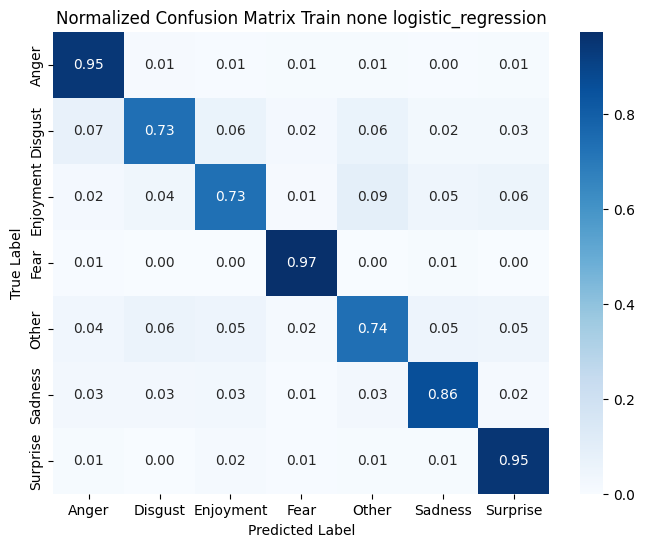

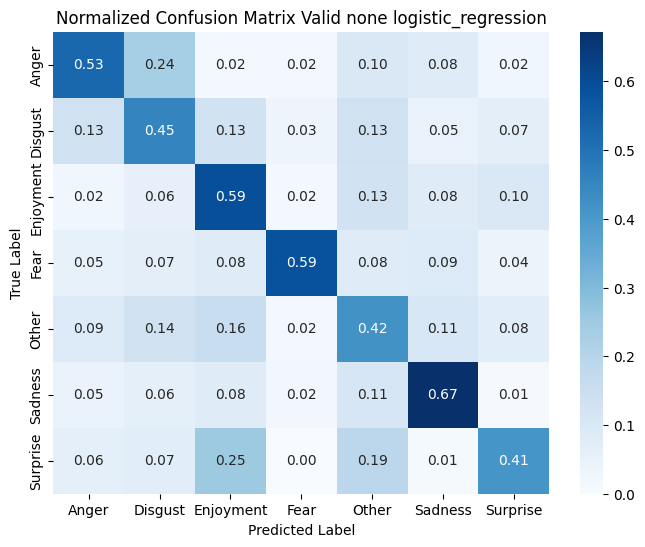

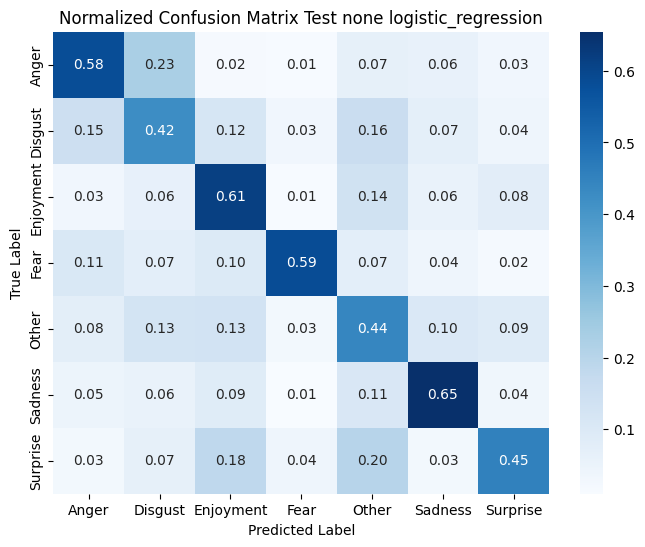

In [40]:
model_82, train_82, valid_82, test_82, pred_82 = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="logistic_regression",
    max_iter=1000
)

# Dự đoán từ pipeline_modeling
y_pred_train_82, y_pred_valid_82, y_pred_test_82 = pred_82

pipeline_evaluation(
    y_train_82, y_valid_82, y_test_82,
    y_pred_train_82, y_pred_valid_82, y_pred_test_82,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77133


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.7459052036527033
Recall: 0.7459052036527033
Precision: 0.7669343719254877
F1-score: 0.7467501400385357

--- valid --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.5327536231884058
Recall: 0.5327536231884058
Precision: 0.5532429371993027
F1-score: 0.5383932762363021

--- test --- 8:2 --- logistic_regression --- pca ---
Accuracy: 0.5426716141001855
Recall: 0.5426716141001855
Precision: 0.5677909299177156
F1-score: 0.5496953034425649


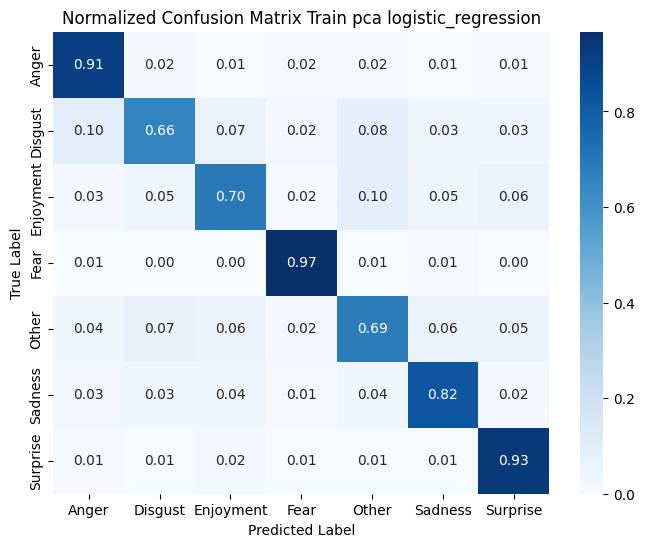

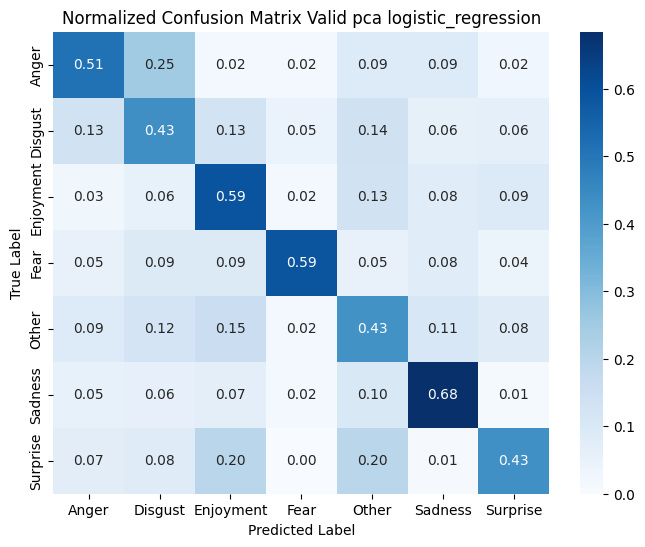

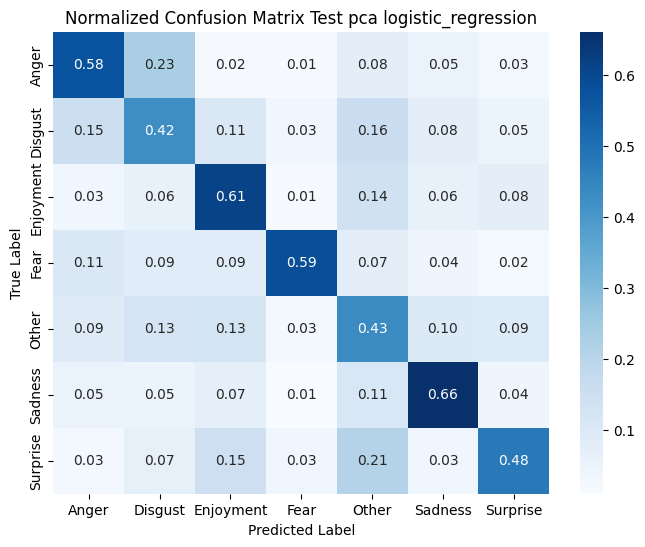

In [41]:
# Chuẩn bị dữ liệu với PCA
X_train_pca_82, X_valid_pca_82, X_test_pca_82, y_train_pca_82, y_valid_pca_82, y_test_pca_82, tfidf_vec_pca_82, disc_model_pca_82 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="pca"
)

# Chạy mô hình Logistic Regression trên dữ liệu PCA
model_pca_82, train_pca_82, valid_pca_82, test_pca_82, pred_pca_82 = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_pca_82, y_valid_pca_82, y_test_pca_82 = train_pca_82[1], valid_pca_82[1], test_pca_82[1]
y_pred_train_pca_82, y_pred_valid_pca_82, y_pred_test_pca_82 = pred_pca_82

pipeline_evaluation(
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    y_pred_train_pca_82, y_pred_valid_pca_82, y_pred_test_pca_82,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6899, 8000) (số câu x số từ vựng)
Số từ vựng: 8000
TF-IDF - Non-zero values: 77133


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.9943470068125815
Recall: 0.9943470068125815
Precision: 0.9944987059005382
F1-score: 0.9943839684072738

--- valid --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.2579710144927536
Recall: 0.2579710144927536
Precision: 0.30959660015201934
F1-score: 0.271929800914076

--- test --- 8:2 --- logistic_regression --- lda ---
Accuracy: 0.26159554730983303
Recall: 0.26159554730983303
Precision: 0.2996202943852817
F1-score: 0.26995990114314067


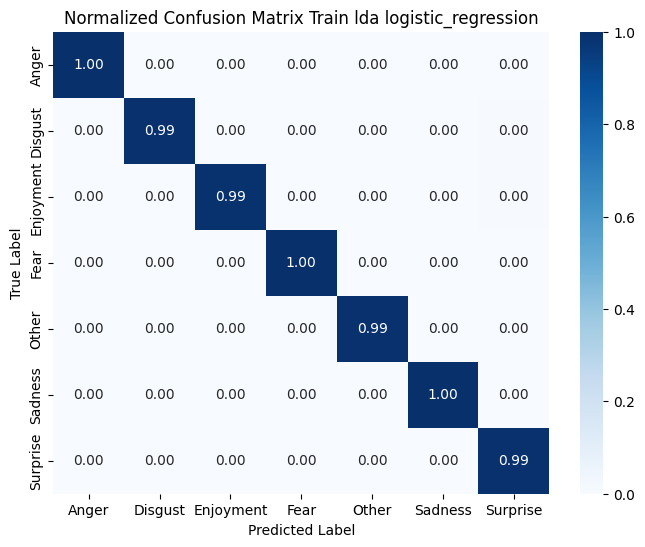

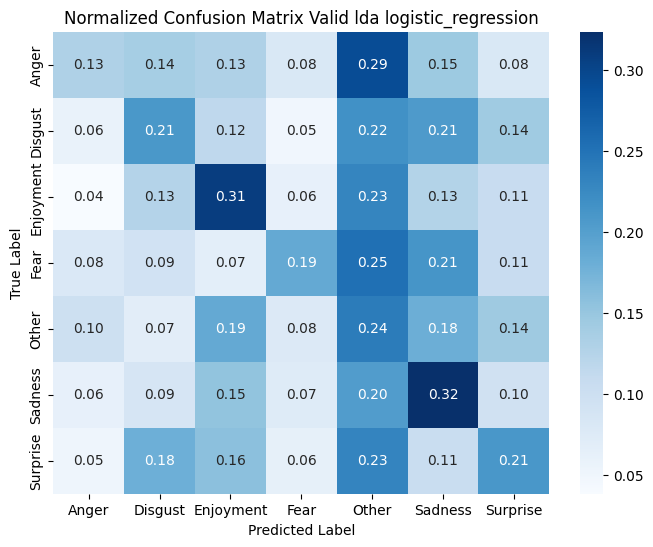

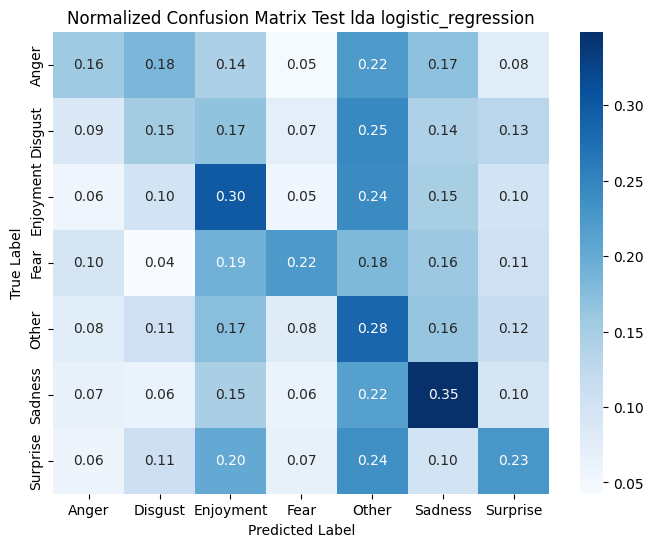

In [42]:
# Chuẩn bị dữ liệu với LDA
X_train_lda_82, X_valid_lda_82, X_test_lda_82, y_train_lda_82, y_valid_lda_82, y_test_lda_82, tfidf_vec_lda_82, disc_model_lda_82 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=8,
    valid_size=2,
    discriminant="lda"
)

# Chạy mô hình Logistic Regression trên dữ liệu LDA
model_lda_82, train_lda_82, valid_lda_82, test_lda_82, pred_lda_82 = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="logistic_regression",
    max_iter=1000
)

y_train_lda_82, y_valid_lda_82, y_test_lda_82 = train_lda_82[1], valid_lda_82[1], test_lda_82[1]
y_pred_train_lda_82, y_pred_valid_lda_82, y_pred_test_lda_82 = pred_lda_82

pipeline_evaluation(
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    y_pred_train_lda_82, y_pred_valid_lda_82, y_pred_test_lda_82,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

--- train --- 8:2 --- knn --- none ---
Accuracy: 0.4796347296709668
Recall: 0.4796347296709668
Precision: 0.539427558639572
F1-score: 0.42378702448499966

--- valid --- 8:2 --- knn --- none ---
Accuracy: 0.45565217391304347
Recall: 0.45565217391304347
Precision: 0.4904513570561634
F1-score: 0.393194175458254

--- test --- 8:2 --- knn --- none ---
Accuracy: 0.45269016697588127
Recall: 0.45269016697588127
Precision: 0.49033861609892415
F1-score: 0.39356162738984984


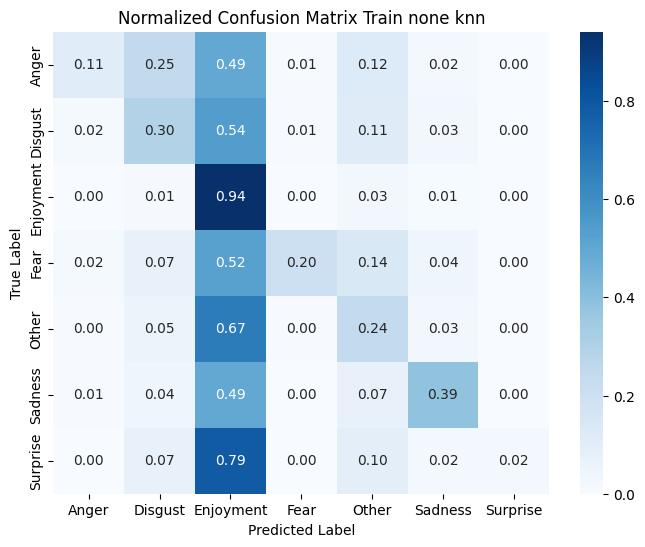

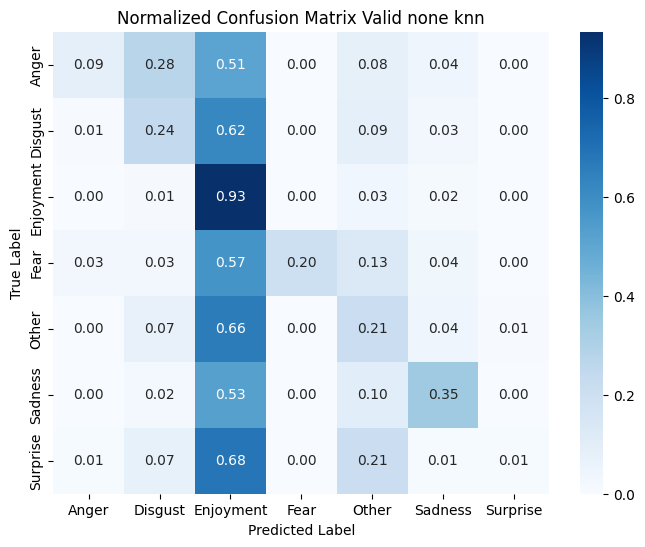

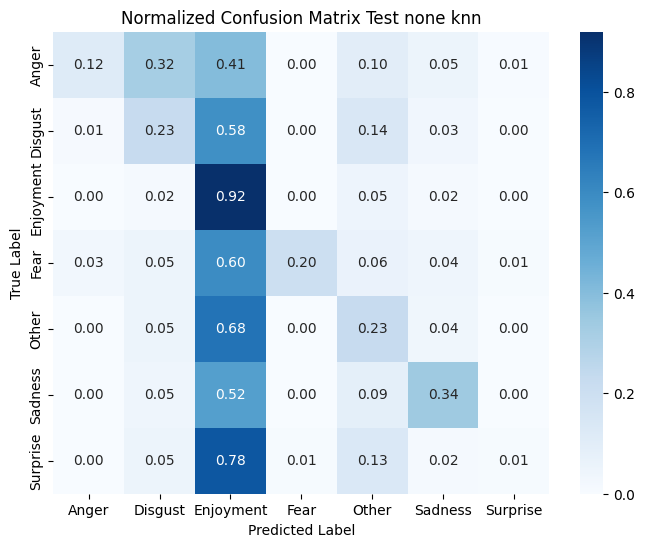

In [43]:
# Chạy KNN trên bộ dữ liệu không giảm chiều 
model_82_knn, train_82_knn, valid_82_knn, test_82_knn, pred_82_knn = pipeline_modeling(
    X_train_82, X_valid_82, X_test_82,
    y_train_82, y_valid_82, y_test_82,
    model_type="knn"
)

y_train_82_knn, y_valid_82_knn, y_test_82_knn = train_82_knn[1], valid_82_knn[1], test_82_knn[1]
y_pred_train_82_knn, y_pred_valid_82_knn, y_pred_test_82_knn = pred_82_knn

pipeline_evaluation(
    y_train_82_knn, y_valid_82_knn, y_test_82_knn,
    y_pred_train_82_knn, y_pred_valid_82_knn, y_pred_test_82_knn,
    train_size=8, valid_size=2,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

--- train --- 8:2 --- knn --- pca ---
Accuracy: 0.48093926656037106
Recall: 0.48093926656037106
Precision: 0.5363048633476475
F1-score: 0.4258617222182837

--- valid --- 8:2 --- knn --- pca ---
Accuracy: 0.4544927536231884
Recall: 0.4544927536231884
Precision: 0.4775360148323458
F1-score: 0.39305191457699645

--- test --- 8:2 --- knn --- pca ---
Accuracy: 0.462430426716141
Recall: 0.462430426716141
Precision: 0.514414675981288
F1-score: 0.4051360335497758


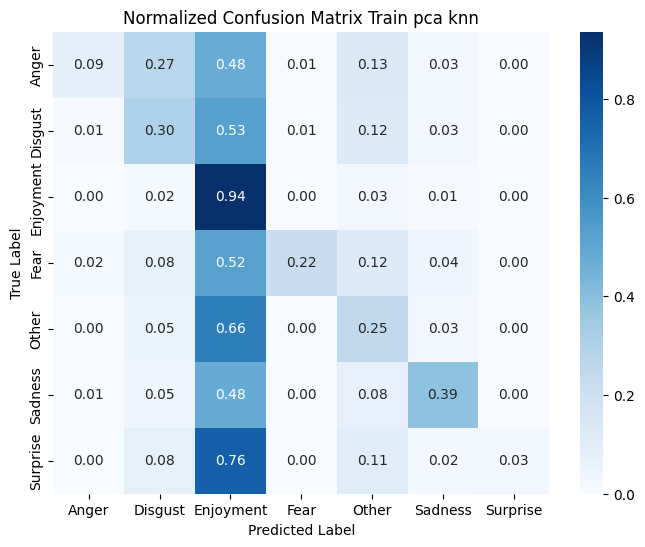

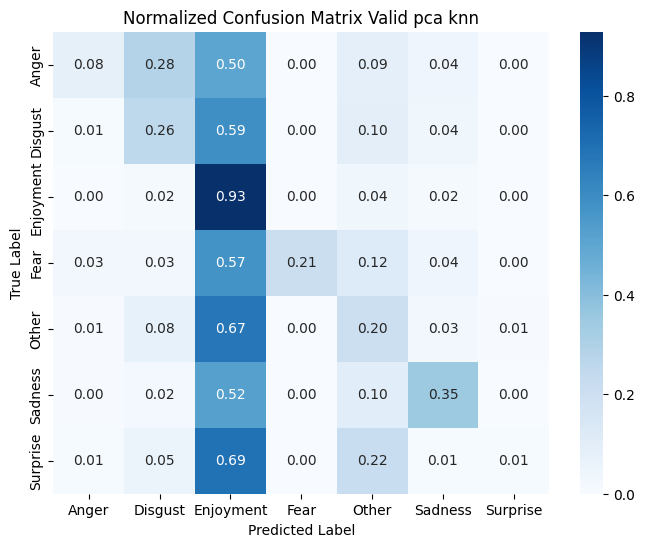

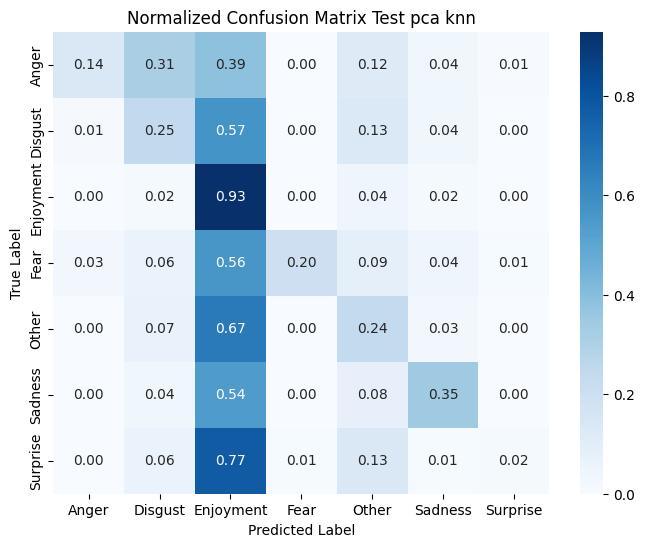

In [44]:
model_pca_82_knn, train_pca_82_knn, valid_pca_82_knn, test_pca_82_knn, pred_pca_82_knn = pipeline_modeling(
    X_train_pca_82, X_valid_pca_82, X_test_pca_82,
    y_train_pca_82, y_valid_pca_82, y_test_pca_82,
    model_type="knn",
    max_iter=1000
)

y_train_pca_82_knn, y_valid_pca_82_knn, y_test_pca_82_knn = train_pca_82_knn[1], valid_pca_82_knn[1], test_pca_82_knn[1]
y_pred_train_pca_82_knn, y_pred_valid_pca_82_knn, y_pred_test_pca_82_knn = pred_pca_82_knn

pipeline_evaluation(
    y_train_pca_82_knn, y_valid_pca_82_knn, y_test_pca_82_knn,
    y_pred_train_pca_82_knn, y_pred_valid_pca_82_knn, y_pred_test_pca_82_knn,
    train_size=8, valid_size=2,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

--- train --- 8:2 --- knn --- lda ---
Accuracy: 0.9933323670097115
Recall: 0.9933323670097115
Precision: 0.9934156389490181
F1-score: 0.9933510803882468

--- valid --- 8:2 --- knn --- lda ---
Accuracy: 0.25217391304347825
Recall: 0.25217391304347825
Precision: 0.329929976050756
F1-score: 0.2709913474876529

--- test --- 8:2 --- knn --- lda ---
Accuracy: 0.25556586270871984
Recall: 0.25556586270871984
Precision: 0.3170426833493304
F1-score: 0.2669240929163504


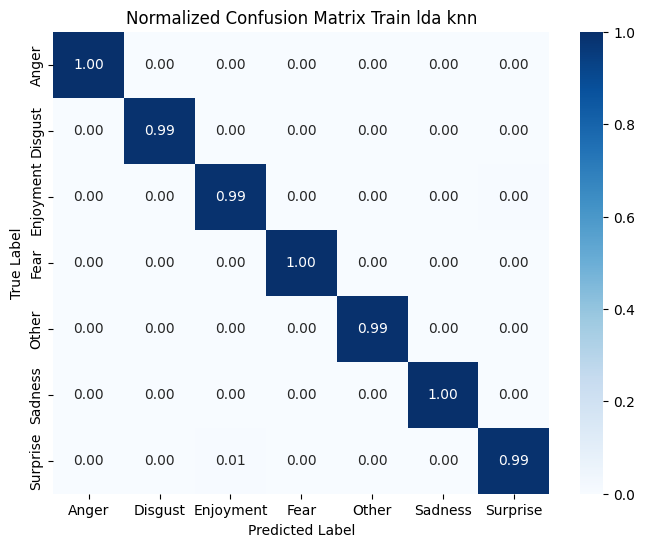

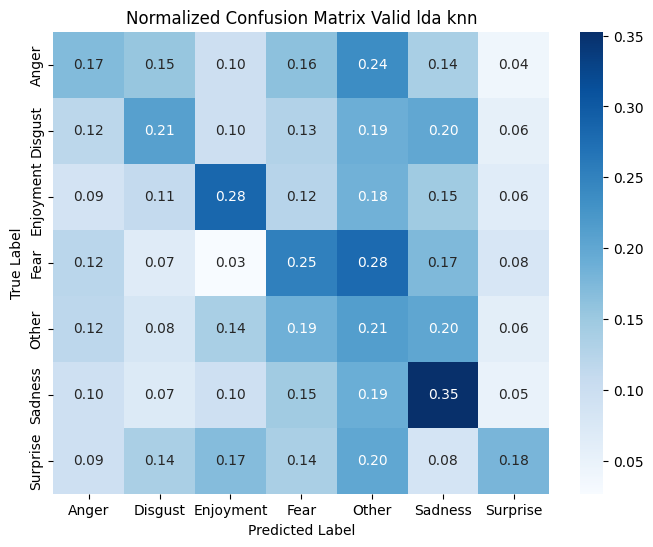

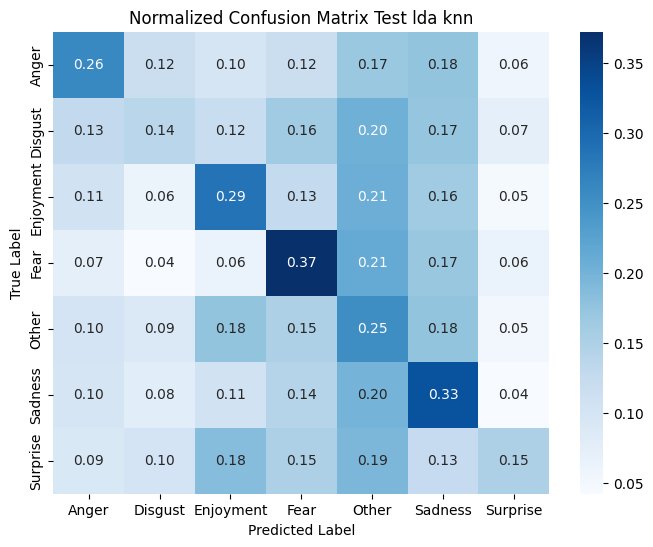

In [45]:
model_lda_82_knn, train_lda_82_knn, valid_lda_82_knn, test_lda_82_knn, pred_lda_82_knn = pipeline_modeling(
    X_train_lda_82, X_valid_lda_82, X_test_lda_82,
    y_train_lda_82, y_valid_lda_82, y_test_lda_82,
    model_type="knn",
    max_iter=1000
)

y_train_lda_82_knn, y_valid_lda_82_knn, y_test_lda_82_knn = train_lda_82_knn[1], valid_lda_82_knn[1], test_lda_82_knn[1]
y_pred_train_lda_82_knn, y_pred_valid_lda_82_knn, y_pred_test_lda_82_knn = pred_lda_82_knn

pipeline_evaluation(
    y_train_lda_82_knn, y_valid_lda_82_knn, y_test_lda_82_knn,
    y_pred_train_lda_82_knn, y_pred_valid_lda_82_knn, y_pred_test_lda_82_knn,
    train_size=8, valid_size=2,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

# Test:Validation = 7:3

## Logistic Regression

### Bộ dữ liệu không giảm chiều

In [46]:
X_train_73, X_valid_73, X_test_73, y_train_73, y_valid_73, y_test_73, tfidf_vec_73, disc_model_73 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="none"
)

TF-IDF hoàn thành!
Shape: (6036, 7986) (số câu x số từ vựng)
Số từ vựng: 7986
TF-IDF - Non-zero values: 68463


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.80649436713055
Recall: 0.80649436713055
Precision: 0.8217422482769744
F1-score: 0.807124010292533

--- valid --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.5255023183925811
Recall: 0.5255023183925811
Precision: 0.543049368576549
F1-score: 0.5310351855542882

--- test --- 7:3 --- logistic_regression --- none ---
Accuracy: 0.5454545454545454
Recall: 0.5454545454545454
Precision: 0.5637728564820472
F1-score: 0.5509492867472386


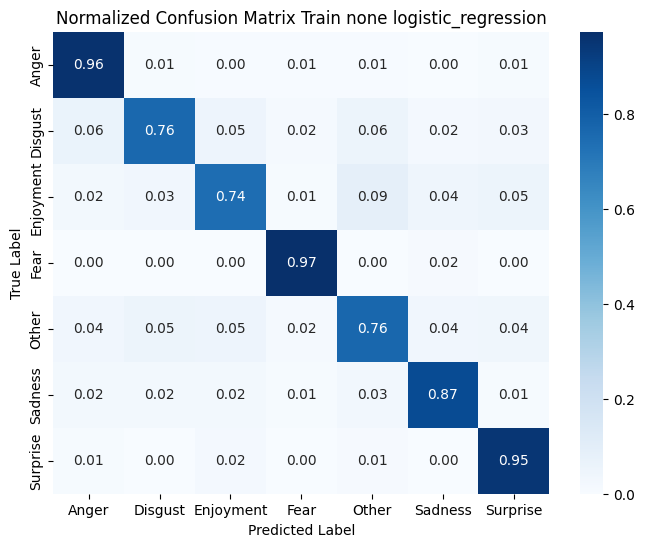

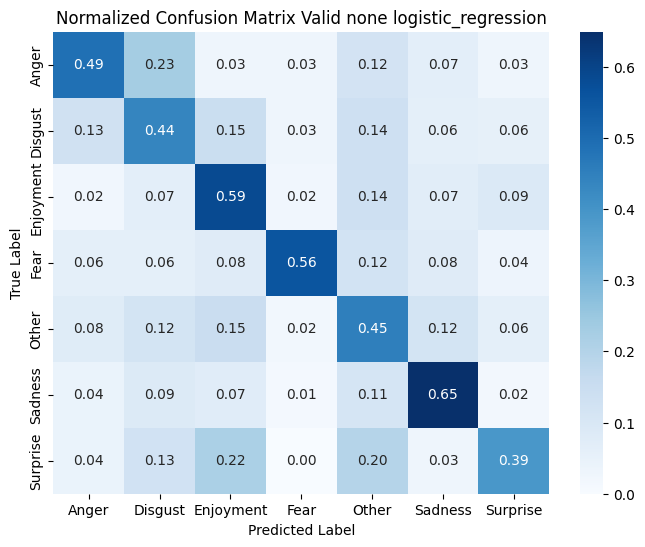

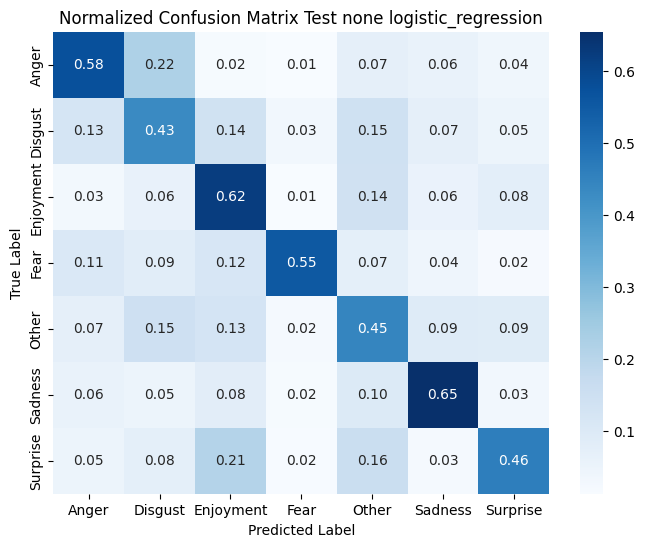

In [47]:
model_73, train_73, valid_73, test_73, pred_73 = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_73, y_pred_valid_73, y_pred_test_73 = pred_73

pipeline_evaluation(
    y_train_73, y_valid_73, y_test_73,
    y_pred_train_73, y_pred_valid_73, y_pred_test_73,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (6036, 7986) (số câu x số từ vựng)
Số từ vựng: 7986
TF-IDF - Non-zero values: 68463


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.7553015241882041
Recall: 0.7553015241882041
Precision: 0.776829457818739
F1-score: 0.7563569414216889

--- valid --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.517774343122102
Recall: 0.517774343122102
Precision: 0.5378076400048378
F1-score: 0.5236313614109792

--- test --- 7:3 --- logistic_regression --- pca ---
Accuracy: 0.5394248608534323
Recall: 0.5394248608534323
Precision: 0.5584128993313643
F1-score: 0.5444583283125426


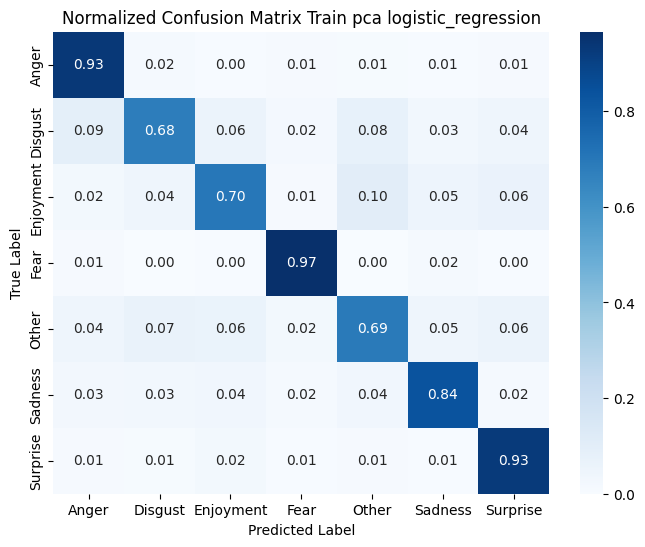

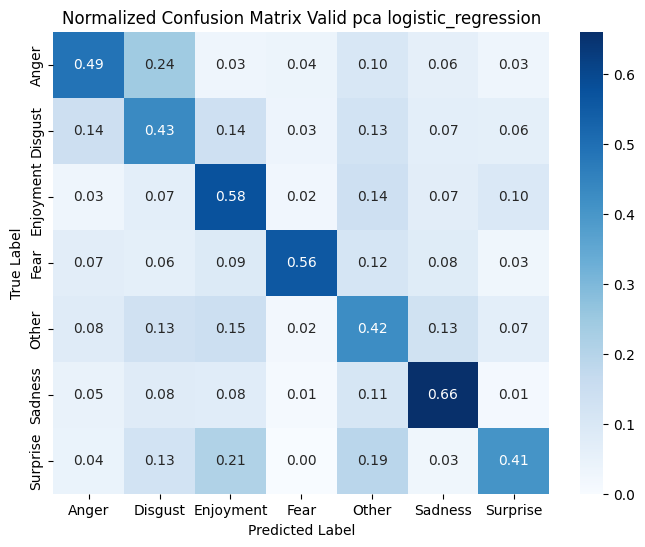

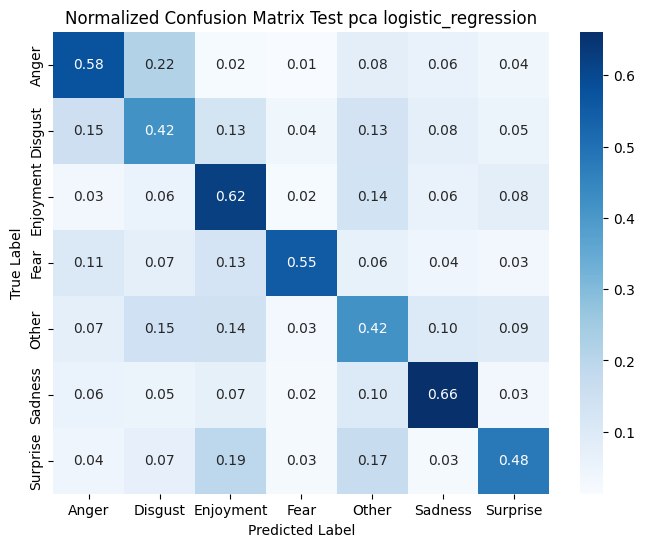

In [48]:
X_train_pca_73, X_valid_pca_73, X_test_pca_73, y_train_pca_73, y_valid_pca_73, y_test_pca_73, tfidf_vec_pca_73, disc_model_pca_73 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="pca"
)

model_pca_73, train_pca_73, valid_pca_73, test_pca_73, pred_pca_73 = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_pca_73, y_pred_valid_pca_73, y_pred_test_pca_73 = pred_pca_73

pipeline_evaluation(
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    y_pred_train_pca_73, y_pred_valid_pca_73, y_pred_test_pca_73,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (6036, 7986) (số câu x số từ vựng)
Số từ vựng: 7986
TF-IDF - Non-zero values: 68463


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.9963552021206097
Recall: 0.9963552021206097
Precision: 0.9964664543114304
F1-score: 0.9963820751085894

--- valid --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.2724111282843895
Recall: 0.2724111282843895
Precision: 0.3350072552603083
F1-score: 0.2896636929486042

--- test --- 7:3 --- logistic_regression --- lda ---
Accuracy: 0.2722634508348794
Recall: 0.2722634508348794
Precision: 0.3389989229422895
F1-score: 0.2893118179860044


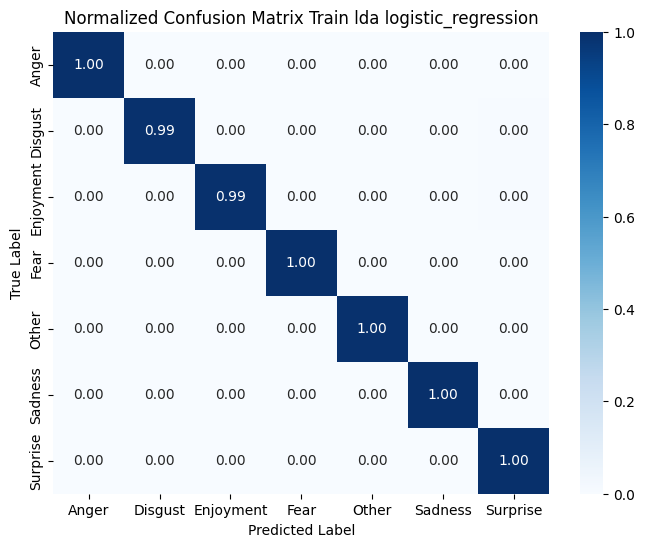

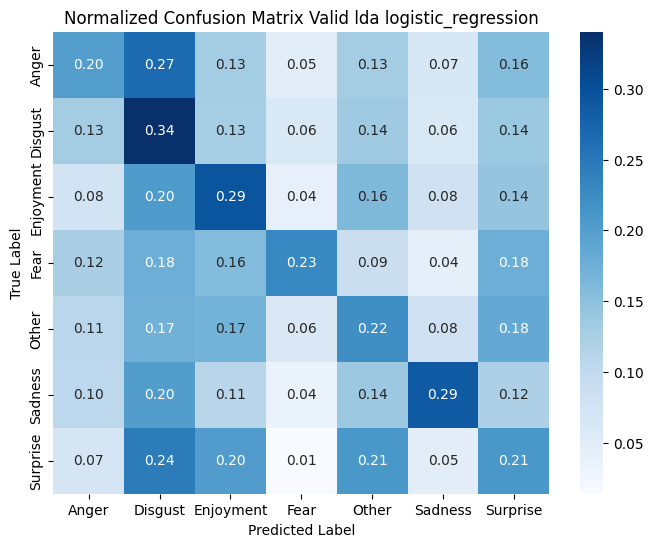

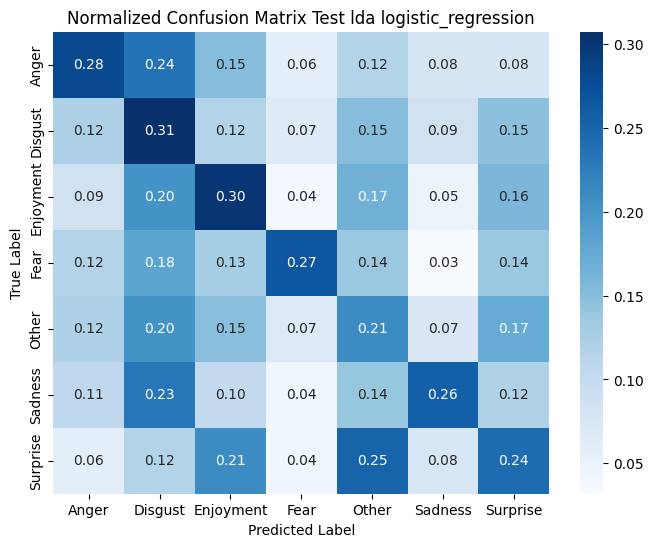

In [49]:
X_train_lda_73, X_valid_lda_73, X_test_lda_73, y_train_lda_73, y_valid_lda_73, y_test_lda_73, tfidf_vec_lda_73, disc_model_lda_73 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=7,
    valid_size=3,
    discriminant="lda"
)

model_lda_73, train_lda_73, valid_lda_73, test_lda_73, pred_lda_73 = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_lda_73, y_pred_valid_lda_73, y_pred_test_lda_73 = pred_lda_73

pipeline_evaluation(
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    y_pred_train_lda_73, y_pred_valid_lda_73, y_pred_test_lda_73,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

--- train --- 7:3 --- knn --- none ---
Accuracy: 0.4761431411530815
Recall: 0.4761431411530815
Precision: 0.5310045213274066
F1-score: 0.42090189765598895

--- valid --- 7:3 --- knn --- none ---
Accuracy: 0.45865533230293665
Recall: 0.45865533230293665
Precision: 0.4948848522474446
F1-score: 0.39945551626087333

--- test --- 7:3 --- knn --- none ---
Accuracy: 0.45918367346938777
Recall: 0.45918367346938777
Precision: 0.5092241078003821
F1-score: 0.40081348392015914


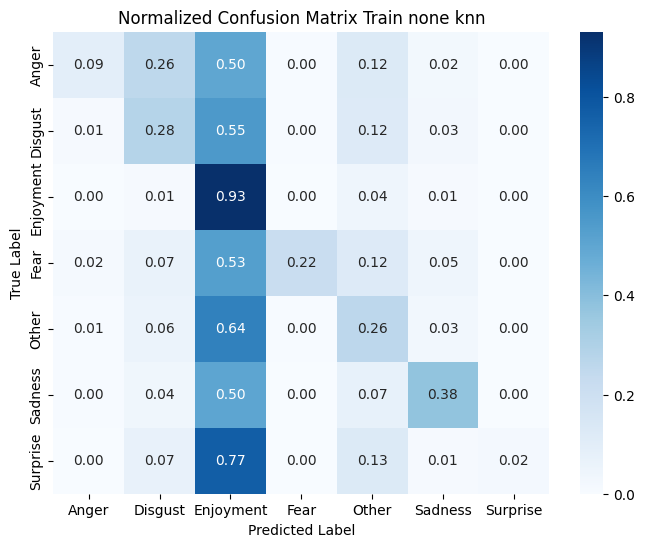

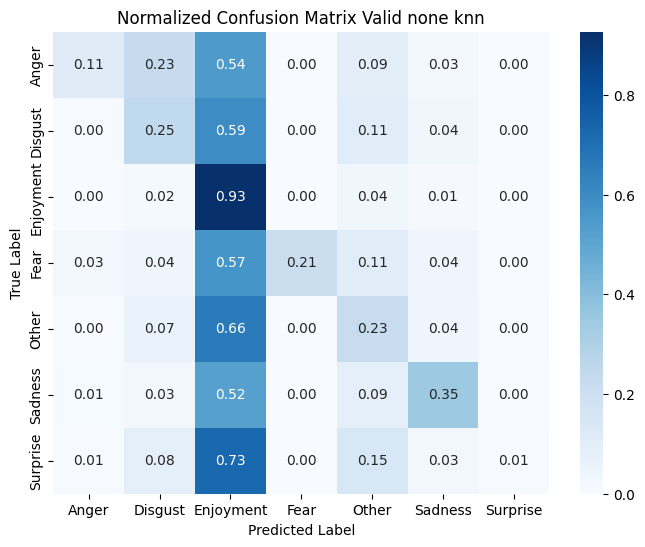

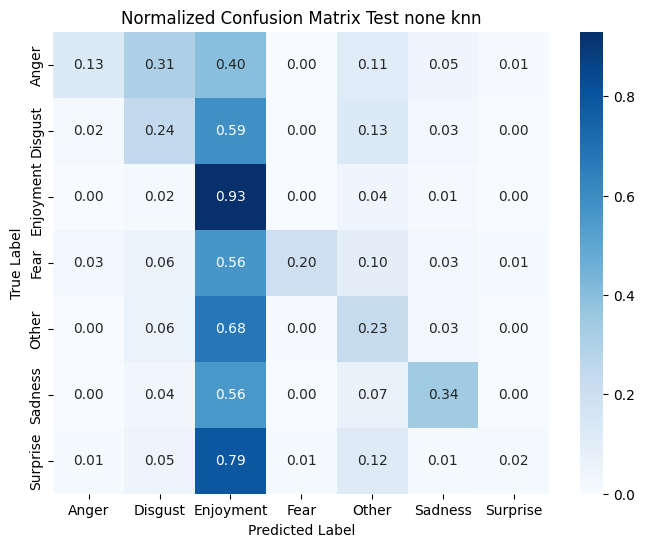

In [50]:
# Chạy KNN trên bộ dữ liệu không giảm chiều 
model_73_knn, train_73_knn, valid_73_knn, test_73_knn, pred_73_knn = pipeline_modeling(
    X_train_73, X_valid_73, X_test_73,
    y_train_73, y_valid_73, y_test_73,
    model_type="knn"
)

y_pred_train_73_knn, y_pred_valid_73_knn, y_pred_test_73_knn = pred_73_knn

pipeline_evaluation(
    y_train_73, y_valid_73, y_test_73,
    y_pred_train_73_knn, y_pred_valid_73_knn, y_pred_test_73_knn,
    train_size=7, valid_size=3,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

--- train --- 7:3 --- knn --- pca ---
Accuracy: 0.47763419483101394
Recall: 0.47763419483101394
Precision: 0.5310847185331534
F1-score: 0.4227812008595888

--- valid --- 7:3 --- knn --- pca ---
Accuracy: 0.46406491499227204
Recall: 0.46406491499227204
Precision: 0.49269419727740044
F1-score: 0.4053342721586271

--- test --- 7:3 --- knn --- pca ---
Accuracy: 0.46567717996289426
Recall: 0.46567717996289426
Precision: 0.515420275052645
F1-score: 0.40775637011260624


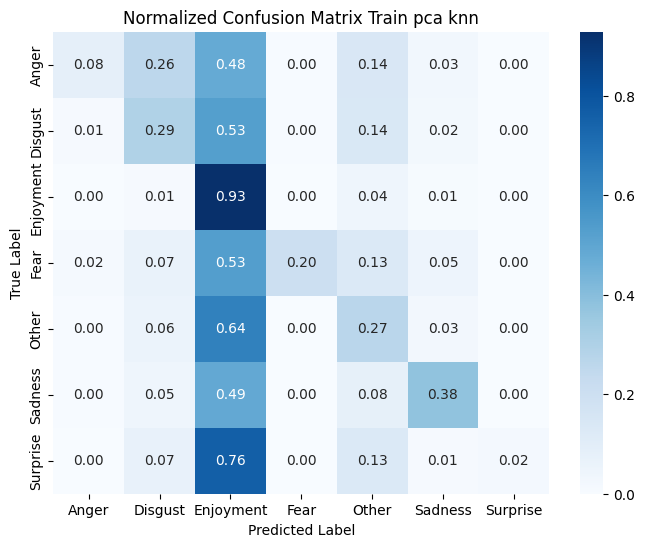

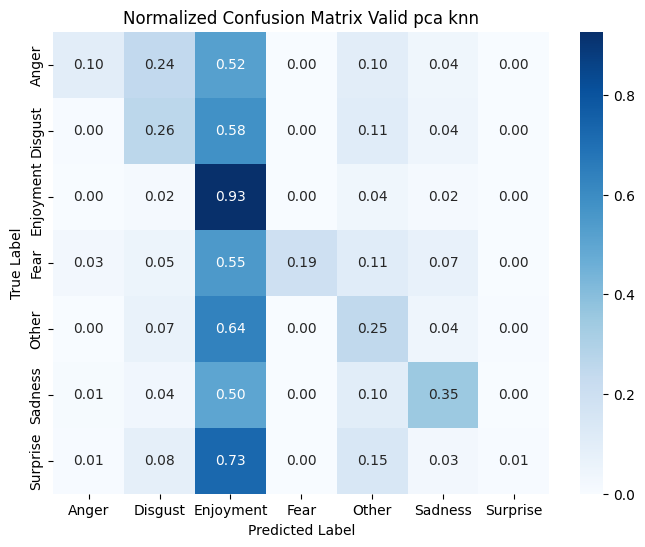

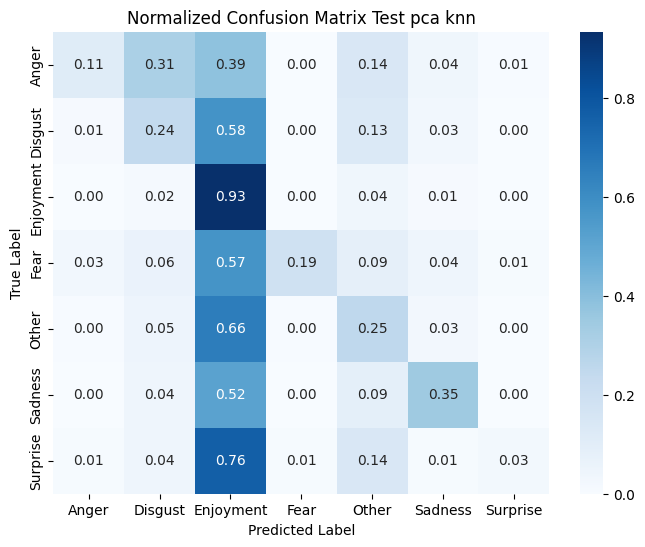

In [51]:
model_pca_73_knn, train_pca_73_knn, valid_pca_73_knn, test_pca_73_knn, pred_pca_73_knn = pipeline_modeling(
    X_train_pca_73, X_valid_pca_73, X_test_pca_73,
    y_train_pca_73, y_valid_pca_73, y_test_pca_73,
    model_type="knn",
    max_iter=1000
)

y_train_pca_73_knn, y_valid_pca_73_knn, y_test_pca_73_knn = train_pca_73_knn[1], valid_pca_73_knn[1], test_pca_73_knn[1]
y_pred_train_pca_73_knn, y_pred_valid_pca_73_knn, y_pred_test_pca_73_knn = pred_pca_73_knn

pipeline_evaluation(
    y_train_pca_73_knn, y_valid_pca_73_knn, y_test_pca_73_knn,
    y_pred_train_pca_73_knn, y_pred_valid_pca_73_knn, y_pred_test_pca_73_knn,
    train_size=7, valid_size=3,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

--- train --- 7:3 --- knn --- lda ---
Accuracy: 0.9950298210735586
Recall: 0.9950298210735586
Precision: 0.9950937018383395
F1-score: 0.9950446621860236

--- valid --- 7:3 --- knn --- lda ---
Accuracy: 0.2693199381761978
Recall: 0.2693199381761978
Precision: 0.34420813342692086
F1-score: 0.2861493919526373

--- test --- 7:3 --- knn --- lda ---
Accuracy: 0.2680890538033395
Recall: 0.2680890538033395
Precision: 0.335842504045043
F1-score: 0.2835365139716269


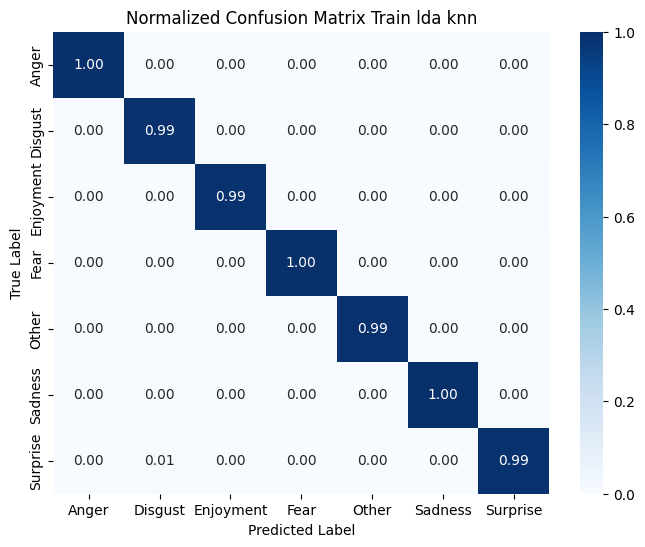

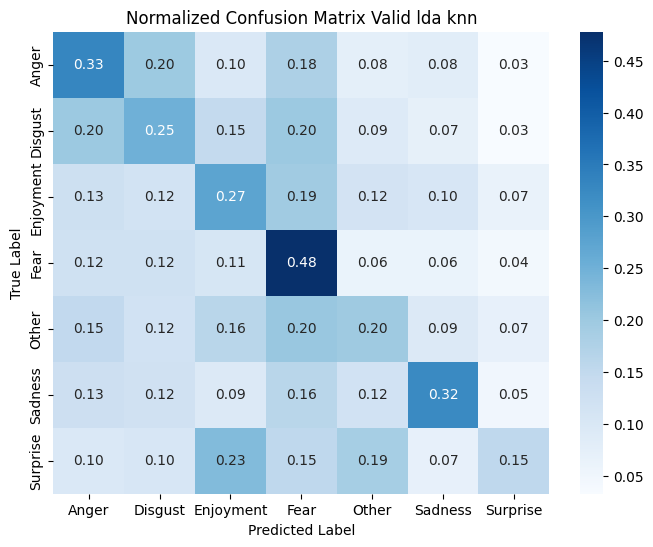

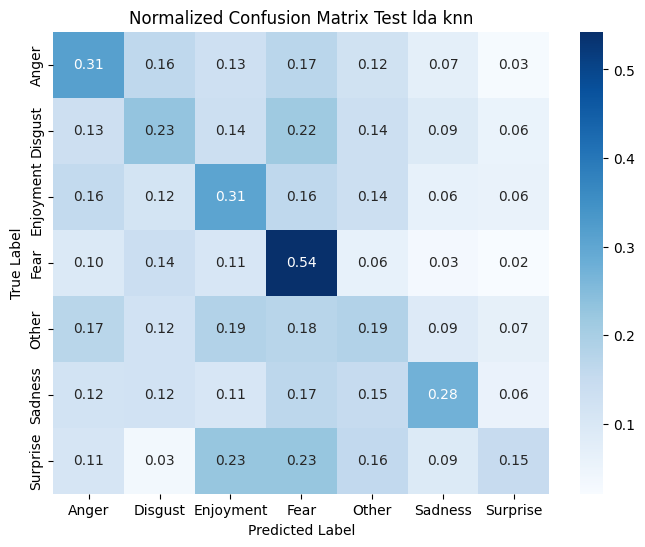

In [52]:

model_lda_73_knn, train_lda_73_knn, valid_lda_73_knn, test_lda_73_knn, pred_lda_73_knn = pipeline_modeling(
    X_train_lda_73, X_valid_lda_73, X_test_lda_73,
    y_train_lda_73, y_valid_lda_73, y_test_lda_73,
    model_type="knn",
    max_iter=1000
)

y_train_lda_73_knn, y_valid_lda_73_knn, y_test_lda_73_knn = train_lda_73_knn[1], valid_lda_73_knn[1], test_lda_73_knn[1]
y_pred_train_lda_73_knn, y_pred_valid_lda_73_knn, y_pred_test_lda_73_knn = pred_lda_73_knn

pipeline_evaluation(
    y_train_lda_73_knn, y_valid_lda_73_knn, y_test_lda_73_knn,
    y_pred_train_lda_73_knn, y_pred_valid_lda_73_knn, y_pred_test_lda_73_knn,
    train_size=7, valid_size=3,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

# Test:Validation = 6:4

## Logistic Regression

### Bộ dữ liệu không giảm chiều

TF-IDF hoàn thành!
Shape: (5174, 6985) (số câu x số từ vựng)
Số từ vựng: 6985
TF-IDF - Non-zero values: 57830


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.8123308851952068
Recall: 0.8123308851952068
Precision: 0.8264285412904423
F1-score: 0.8126912139956882

--- valid --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.5171014492753623
Recall: 0.5171014492753623
Precision: 0.5368644714817459
F1-score: 0.5239023374310808

--- test --- 6:4 --- logistic_regression --- none ---
Accuracy: 0.5315398886827458
Recall: 0.5315398886827458
Precision: 0.5501262528543915
F1-score: 0.5373004035470712


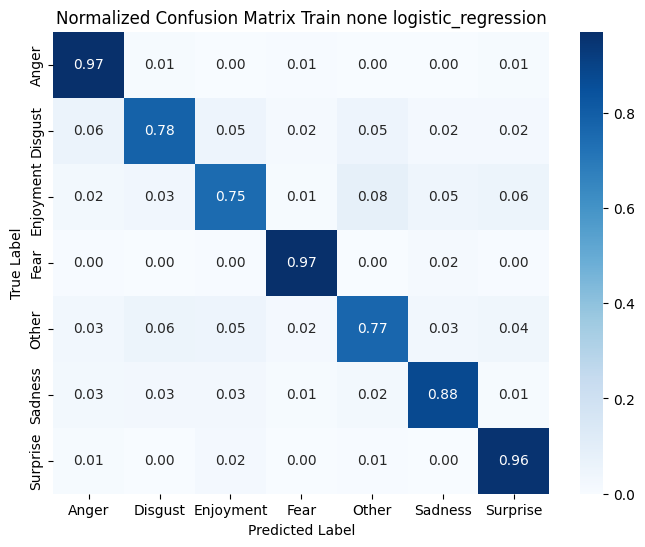

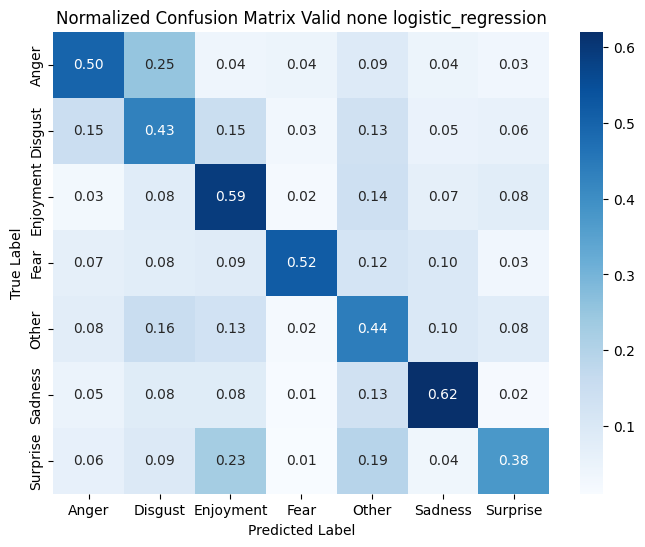

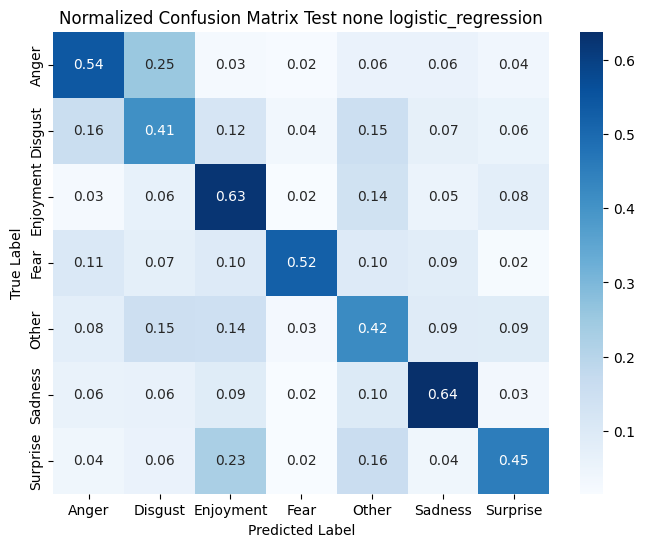

In [53]:
X_train_64, X_valid_64, X_test_64, y_train_64, y_valid_64, y_test_64, tfidf_vec_64, disc_model_64 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="none"
)

model_64, train_64, valid_64, test_64, pred_64 = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_64, y_pred_valid_64, y_pred_test_64 = pred_64
pipeline_evaluation(
    y_train_64, y_valid_64, y_test_64,
    y_pred_train_64, y_pred_valid_64, y_pred_test_64,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu PCA

TF-IDF hoàn thành!
Shape: (5174, 6985) (số câu x số từ vựng)
Số từ vựng: 6985
TF-IDF - Non-zero values: 57830


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- pca ---
Accuracy: 0.7643989176652494
Recall: 0.7643989176652494
Precision: 0.7851235933133816
F1-score: 0.7654931674346974

--- valid --- 6:4 --- logistic_regression --- pca ---
Accuracy: 0.5057971014492754
Recall: 0.5057971014492754
Precision: 0.52941994540863
F1-score: 0.5134498122800267

--- test --- 6:4 --- logistic_regression --- pca ---
Accuracy: 0.5231910946196661
Recall: 0.5231910946196661
Precision: 0.5428173968749166
F1-score: 0.5287502548907904


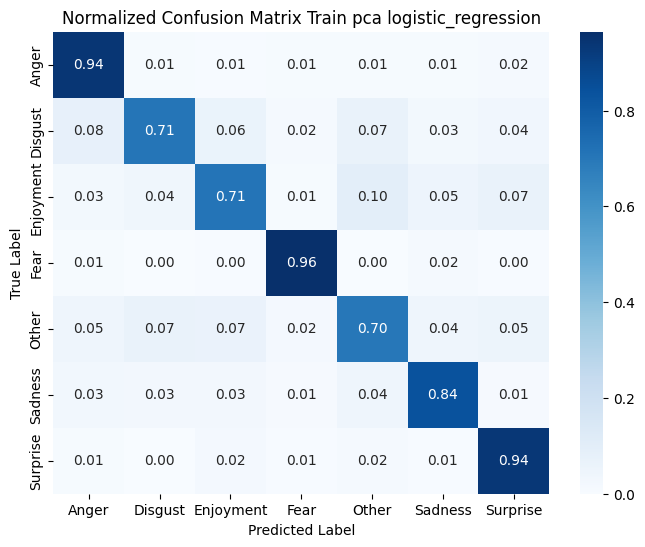

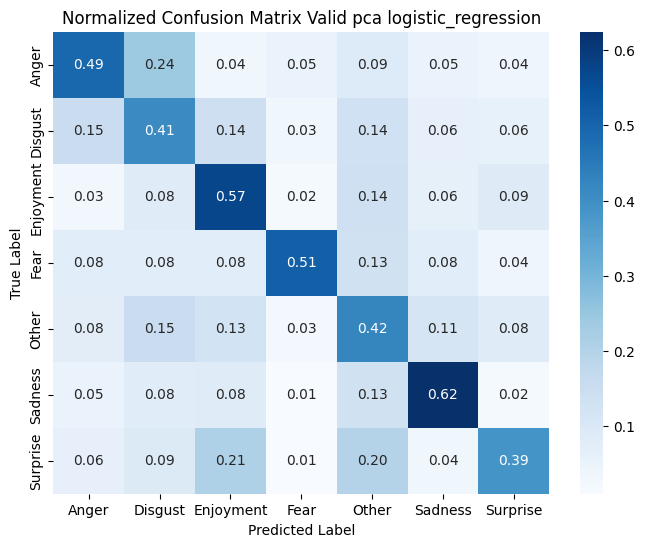

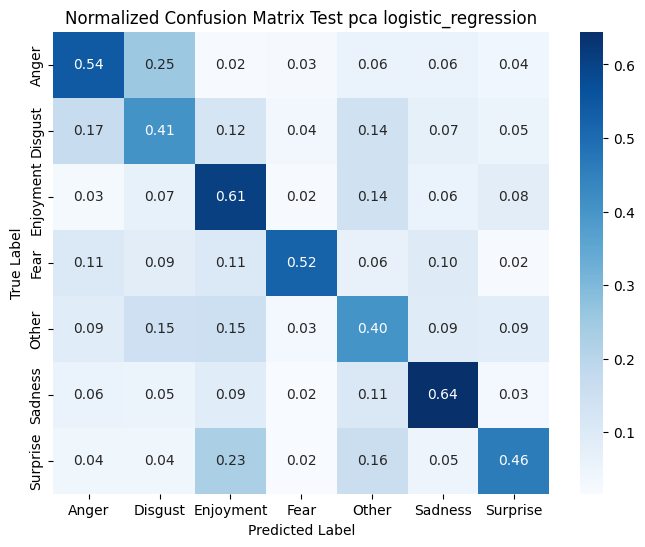

In [54]:
X_train_pca_64, X_valid_pca_64, X_test_pca_64, y_train_pca_64, y_valid_pca_64, y_test_pca_64, tfidf_vec_pca_64, disc_model_pca_64 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="pca"
)

model_pca_64, train_pca_64, valid_pca_64, test_pca_64, pred_pca_64 = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_pca_64, y_pred_valid_pca_64, y_pred_test_pca_64 = pred_pca_64

pipeline_evaluation(
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    y_pred_train_pca_64, y_pred_valid_pca_64, y_pred_test_pca_64,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="logistic_regression",
    show_plot=True
)

### Bộ dữ liệu lda

TF-IDF hoàn thành!
Shape: (5174, 6985) (số câu x số từ vựng)
Số từ vựng: 6985
TF-IDF - Non-zero values: 57830


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


--- train --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.9976807112485504
Recall: 0.9976807112485504
Precision: 0.9977454426637807
F1-score: 0.9976954425458414

--- valid --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.25623188405797104
Recall: 0.25623188405797104
Precision: 0.3138364620271498
F1-score: 0.2693206962828654

--- test --- 6:4 --- logistic_regression --- lda ---
Accuracy: 0.2592764378478664
Recall: 0.2592764378478664
Precision: 0.31811730805367977
F1-score: 0.2743750338934628


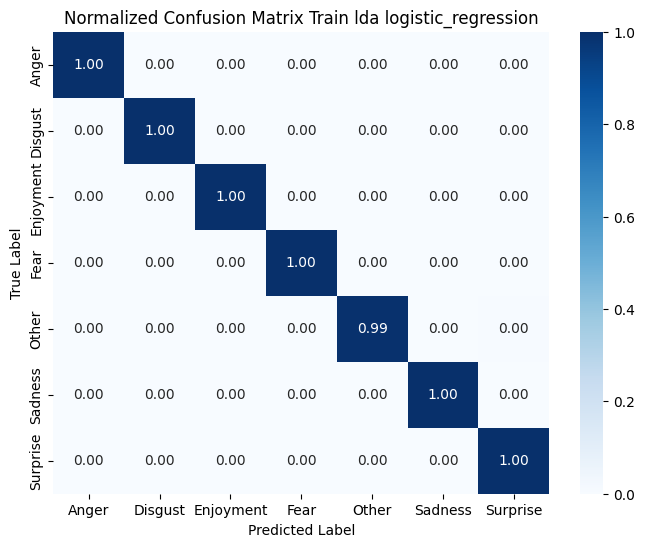

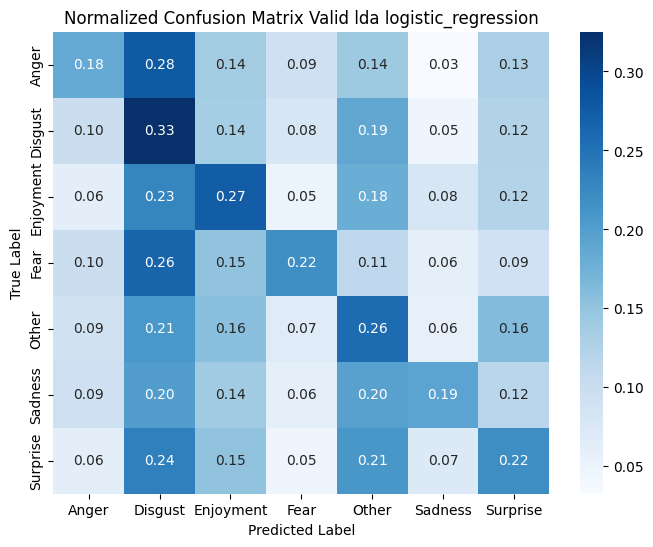

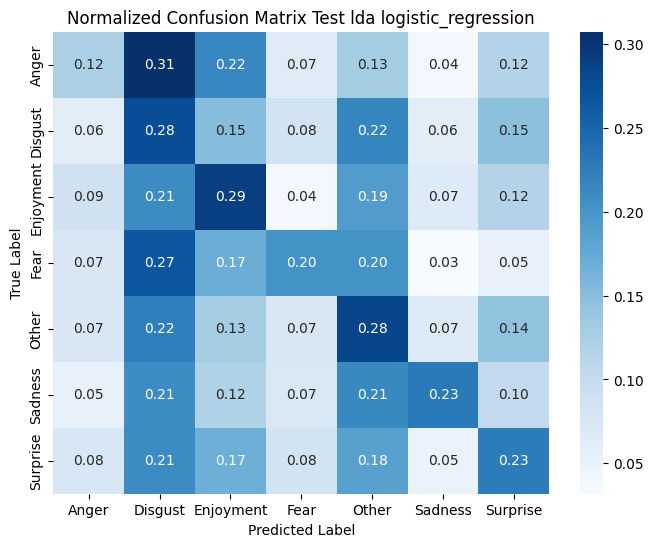

In [55]:
X_train_lda_64, X_valid_lda_64, X_test_lda_64, y_train_lda_64, y_valid_lda_64, y_test_lda_64, tfidf_vec_lda_64, disc_model_lda_64 = prepare_data_for_modeling(
    train_valid_processed_comments,
    test_processed_comments,
    train_size=6,
    valid_size=4,
    discriminant="lda"
)

model_lda_64, train_lda_64, valid_lda_64, test_lda_64, pred_lda_64 = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="logistic_regression",
    max_iter=1000
)

y_pred_train_lda_64, y_pred_valid_lda_64, y_pred_test_lda_64 = pred_lda_64

pipeline_evaluation(
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    y_pred_train_lda_64, y_pred_valid_lda_64, y_pred_test_lda_64,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="logistic_regression",
    show_plot=True
)

## K-NN

### Bộ dữ liệu không giảm chiều

--- train --- 6:4 --- knn --- none ---
Accuracy: 0.4723618090452261
Recall: 0.4723618090452261
Precision: 0.5329958521326246
F1-score: 0.4165439672231605

--- valid --- 6:4 --- knn --- none ---
Accuracy: 0.45159420289855073
Recall: 0.45159420289855073
Precision: 0.4957317296723924
F1-score: 0.38958765619536

--- test --- 6:4 --- knn --- none ---
Accuracy: 0.4582560296846011
Recall: 0.4582560296846011
Precision: 0.5196901220255553
F1-score: 0.3992524139964641


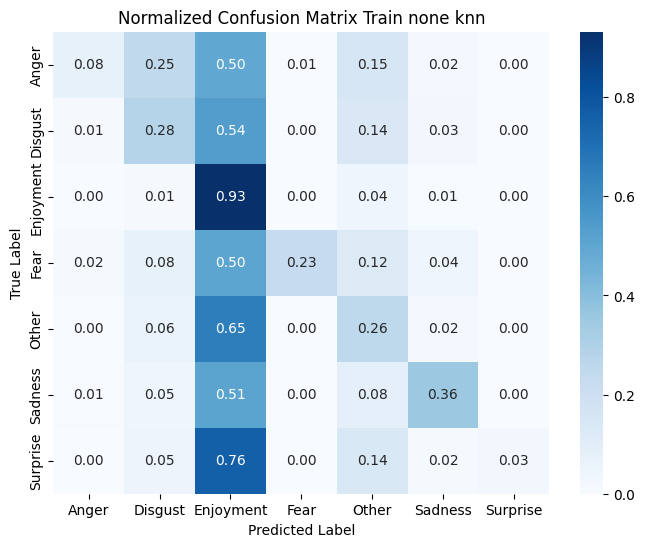

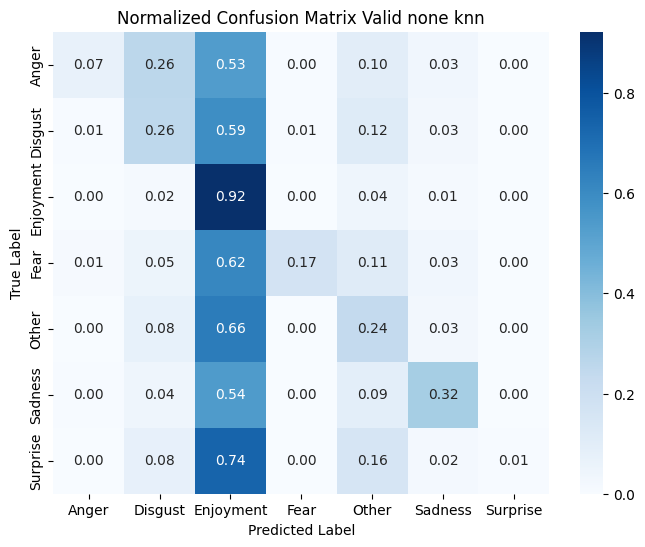

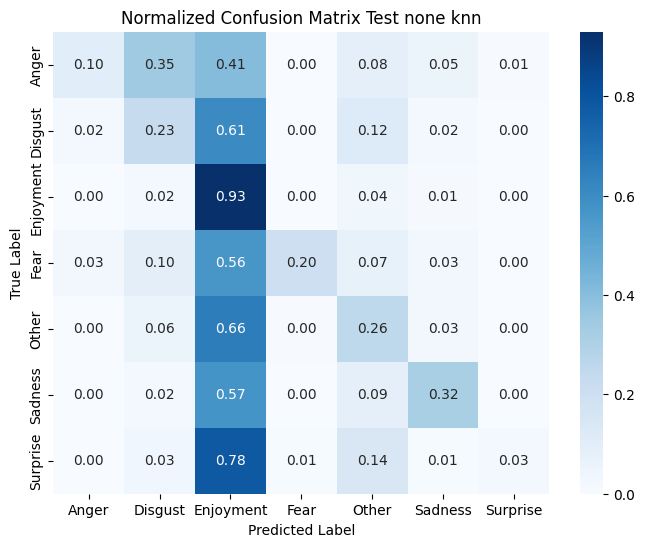

In [56]:
model_64_knn, train_64_knn, valid_64_knn, test_64_knn, pred_64_knn = pipeline_modeling(
    X_train_64, X_valid_64, X_test_64,
    y_train_64, y_valid_64, y_test_64,
    model_type="knn"
)

y_train_64_knn, y_valid_64_knn, y_test_64_knn = train_64_knn[1], valid_64_knn[1], test_64_knn[1]
y_pred_train_64_knn, y_pred_valid_64_knn, y_pred_test_64_knn = pred_64_knn

pipeline_evaluation(
    y_train_64_knn, y_valid_64_knn, y_test_64_knn,
    y_pred_train_64_knn, y_pred_valid_64_knn, y_pred_test_64_knn,
    train_size=6, valid_size=4,
    discriminant="none",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu PCA

--- train --- 6:4 --- knn --- pca ---
Accuracy: 0.47139543873212214
Recall: 0.47139543873212214
Precision: 0.5301913130916786
F1-score: 0.41570677082778423

--- valid --- 6:4 --- knn --- pca ---
Accuracy: 0.456231884057971
Recall: 0.456231884057971
Precision: 0.4768370618597901
F1-score: 0.39686786330827994

--- test --- 6:4 --- knn --- pca ---
Accuracy: 0.45918367346938777
Recall: 0.45918367346938777
Precision: 0.5150076496490601
F1-score: 0.4010860295534578


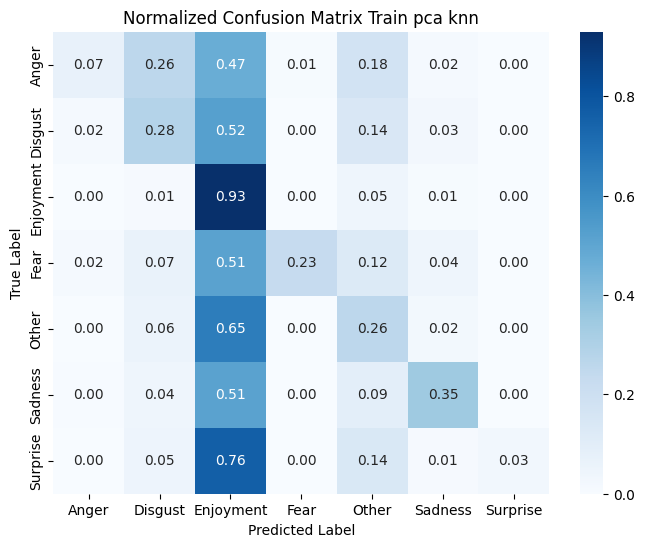

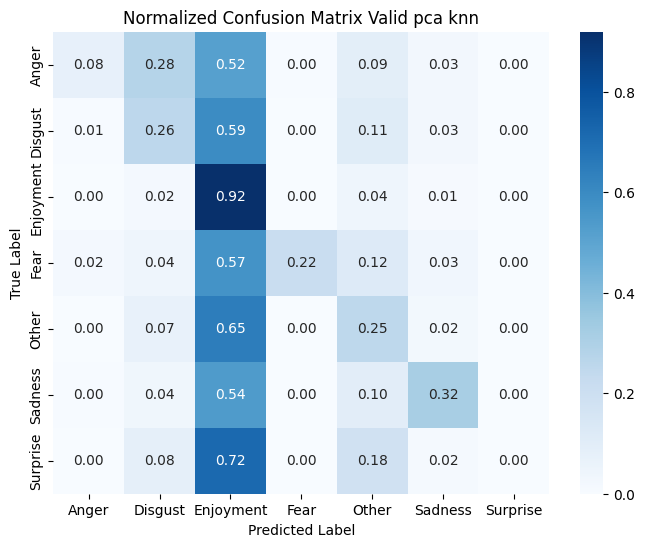

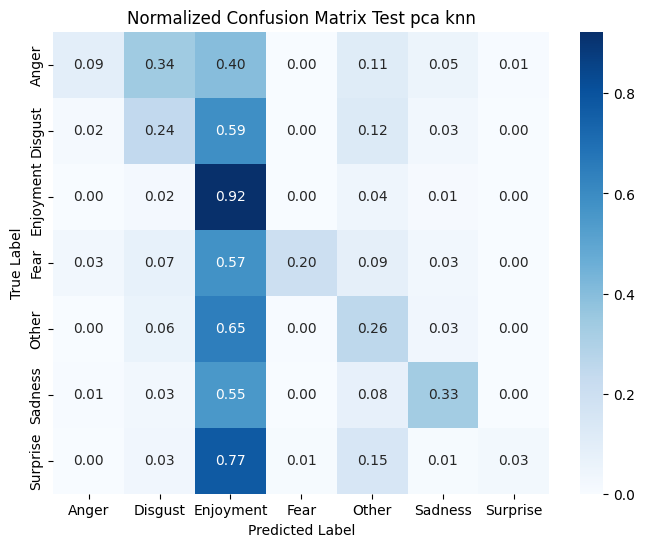

In [57]:

model_pca_64_knn, train_pca_64_knn, valid_pca_64_knn, test_pca_64_knn, pred_pca_64_knn = pipeline_modeling(
    X_train_pca_64, X_valid_pca_64, X_test_pca_64,
    y_train_pca_64, y_valid_pca_64, y_test_pca_64,
    model_type="knn",
    max_iter=1000
)

y_train_pca_64_knn, y_valid_pca_64_knn, y_test_pca_64_knn = train_pca_64_knn[1], valid_pca_64_knn[1], test_pca_64_knn[1]
y_pred_train_pca_64_knn, y_pred_valid_pca_64_knn, y_pred_test_pca_64_knn = pred_pca_64_knn

pipeline_evaluation(
    y_train_pca_64_knn, y_valid_pca_64_knn, y_test_pca_64_knn,
    y_pred_train_pca_64_knn, y_pred_valid_pca_64_knn, y_pred_test_pca_64_knn,
    train_size=6, valid_size=4,
    discriminant="pca",
    model_type="knn",
    show_plot=True
)

### Bộ dữ liệu lda

--- train --- 6:4 --- knn --- lda ---
Accuracy: 0.9957479706223424
Recall: 0.9957479706223424
Precision: 0.995773645160491
F1-score: 0.9957498543140142

--- valid --- 6:4 --- knn --- lda ---
Accuracy: 0.2591304347826087
Recall: 0.2591304347826087
Precision: 0.3395777991250579
F1-score: 0.27504245021872625

--- test --- 6:4 --- knn --- lda ---
Accuracy: 0.2569573283858998
Recall: 0.2569573283858998
Precision: 0.3262508422779436
F1-score: 0.2726266216165098


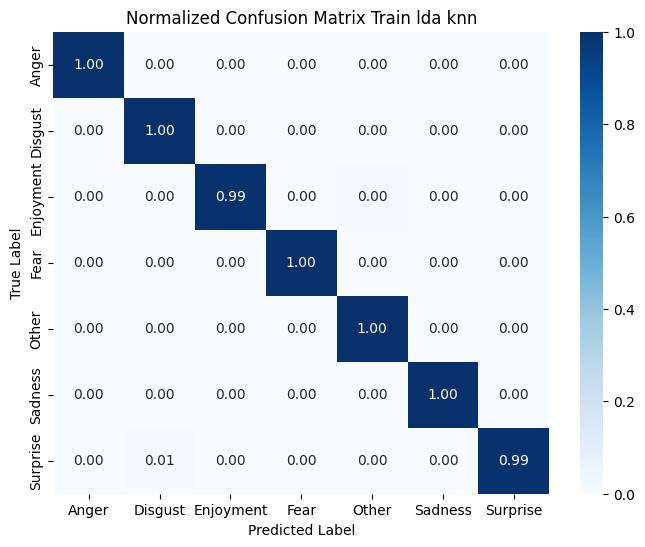

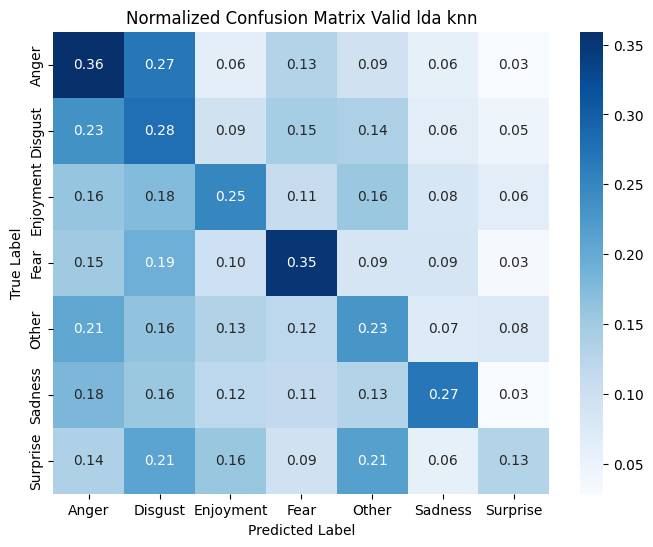

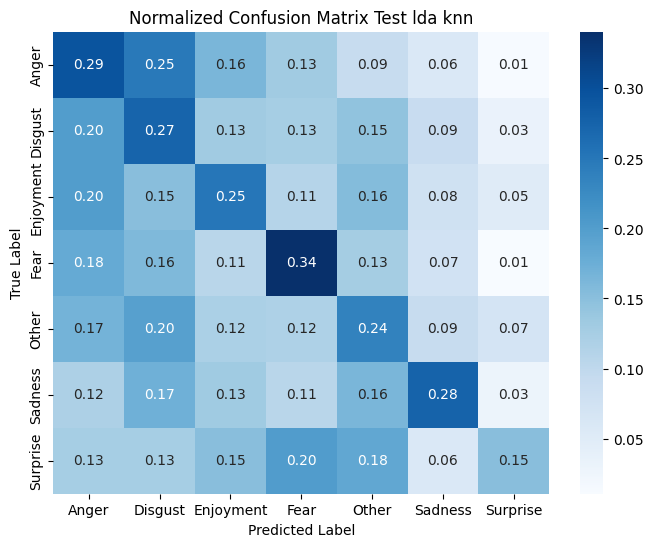

In [58]:

model_lda_64_knn, train_lda_64_knn, valid_lda_64_knn, test_lda_64_knn, pred_lda_64_knn = pipeline_modeling(
    X_train_lda_64, X_valid_lda_64, X_test_lda_64,
    y_train_lda_64, y_valid_lda_64, y_test_lda_64,
    model_type="knn",
    max_iter=1000
)

y_train_lda_64_knn, y_valid_lda_64_knn, y_test_lda_64_knn = train_lda_64_knn[1], valid_lda_64_knn[1], test_lda_64_knn[1]
y_pred_train_lda_64_knn, y_pred_valid_lda_64_knn, y_pred_test_lda_64_knn = pred_lda_64_knn

pipeline_evaluation(
    y_train_lda_64_knn, y_valid_lda_64_knn, y_test_lda_64_knn,
    y_pred_train_lda_64_knn, y_pred_valid_lda_64_knn, y_pred_test_lda_64_knn,
    train_size=6, valid_size=4,
    discriminant="lda",
    model_type="knn",
    show_plot=True
)

# Xem F1

In [87]:
from sklearn.metrics import classification_report

print(classification_report(y_test_73, y_pred_test_73, digits=4))

              precision    recall  f1-score   support

       Anger     0.4037    0.5752    0.4744       153
     Disgust     0.4755    0.4330    0.4532       358
   Enjoyment     0.7267    0.6201    0.6692       716
        Fear     0.5532    0.5532    0.5532        94
       Other     0.4568    0.4458    0.4512       415
     Sadness     0.6176    0.6545    0.6355       301
    Surprise     0.3005    0.4622    0.3642       119

    accuracy                         0.5455      2156
   macro avg     0.5048    0.5348    0.5144      2156
weighted avg     0.5638    0.5455    0.5509      2156



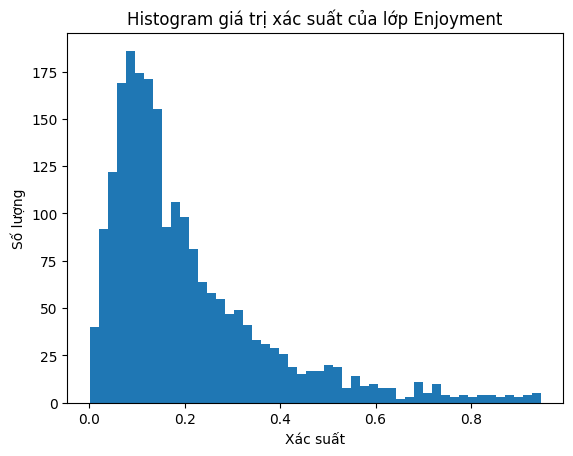

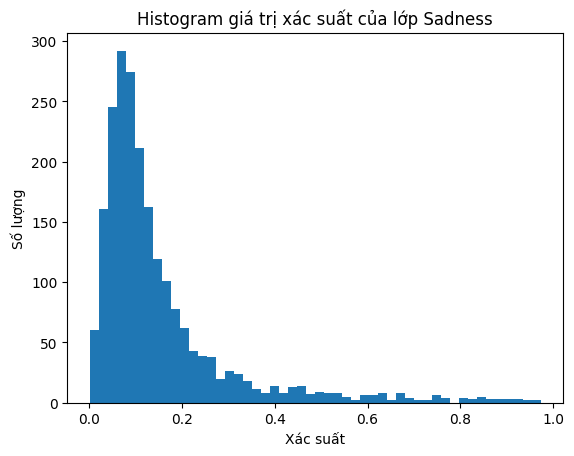

In [ ]:
def plot_score_hist(model, X, label_name):
    scores = model.predict_proba(X)       # Trả về giá trị hàm quyết định
    classes = list(model.classes_)       # Các lớp của mô hình 

    # Lấy index của lớp lable_name
    idx = classes.index(label_name)
    
    # Lấy ra cột score của nhãn label_name 
    score = scores[:, idx]  

    plt.figure()
    plt.hist(score, bins=50)
    plt.title(f"Histogram giá trị xác suất của lớp {label_name}")
    plt.xlabel("Xác suất")
    plt.ylabel("Số lượng")
    plt.show()
    
    return score
    
# Chọn 1 mô hình bất kì   
model = model_82         # model logistic regression đã huấn luyện
X_test_processed, y_test = test_82

score_enj = plot_score_hist(model, X_test_processed, "Enjoyment")
score_sad = plot_score_hist(model, X_test_processed, "Sadness")

Nhận xét: 


- Lớp Enjoyment có F1 cao nhất và số lượng nhãn lớn nhất => Ổn định, ít nhiễu hơn và ít giao động khi chia tập DL 

- Dựa vào histogram ta thấy phân bố của lớp Enjoyment khá mượt và trải rộng => có nhiều mức điểm khác nhau cho mô hình ==> phù hợp làm đầu ra hồi quy

- Lớp Sadness cũng là một sự lựa chọn ổn, tuy nhiên phân bố không quá đẹp, không ổn định bằng Enjoyment và F1-Score của 2 lớp này cũng không chênh lệch nhiều

=> Chọn đầu ra hồi quy là giá trị hàm quyết định của lớp Enjoyment

# Chuyển bài toán sang hồi quy


## Các hàm xử lý cho hồi quy

In [61]:
import numpy as np
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA


### Hàm lấy softmax probability của lớp Enjoyment


In [ ]:
def get_enjoyment_score(model, X_data):

    # Lấy tất cả softmax probabilities cho tất cả các lớp
    probabilities = model.predict_proba(X_data)  # Shape: (n_samples, n_classes)
    
    # Tìm index của lớp Enjoyment
    classes = list(model.classes_)
    idx_enjoyment = classes.index("Enjoyment")
    
    # Lấy cột probability của lớp Enjoyment
    prob_enjoyment = probabilities[:, idx_enjoyment]
    
    return prob_enjoyment


### Hàm đánh giá mô hình hồi quy (MSE, MAE, R2)


In [63]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {"MSE": mse, "MAE": mae, "R2": r2}


### Hồi quy tuyến tính (L2 regularization)


In [64]:
# alpha: hệ số regularization
def train_ridge(X_train, y_train, alpha=1.0, random_state=11):
    ridge = Ridge(alpha=alpha, random_state=random_state)
    ridge.fit(X_train, y_train)
    return ridge


### KNN


In [65]:
def train_knn_regressor(X_train, y_train, metric='cosine', n_jobs=-1):
    k = int(np.sqrt(len(X_train)))
    knn = KNeighborsRegressor(n_neighbors=k, metric=metric, n_jobs=n_jobs)
    knn.fit(X_train, y_train)
    return knn


### Hàm lựa chọn mô hình hồi quy


Hệ số cho mô hình
- model_type: loại mô hình
- alpha: hệ số regularization 
- metric: metric của KNN (cosine,...)

In [66]:
def use_regression_model(model_type, X_train, y_train, alpha=1.0, metric='cosine'):
    if model_type == "ridge":
        return train_ridge(X_train, y_train, alpha=alpha)
    elif model_type == "knn":
        return train_knn_regressor(X_train, y_train, metric=metric)
    else:
        raise ValueError(f"Unknown model_type: {model_type}. Use 'ridge' or 'knn'")


### Hàm dự đoán hồi quy


In [67]:
def predict_regression(model, X_train, X_valid, X_test):
    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    y_pred_test = model.predict(X_test)
    
    return y_pred_train, y_pred_valid, y_pred_test


### Hàm chuẩn bị dữ liệu 

- Input là dữ liệu sau TF-IDF của model lựa chọn (model đã trả về dữ liệu này)
- Lấy softmax probabilities từ model có kết quả phân loại tốt nhất (chọn model_73)
- Áp dụng PCA (1/3, tùy chọn)

In [ ]:
def prepare_data_for_regression(classification_model, X_train_valid, X_test, 
                                 y_train_valid, y_test,
                                 train_size=7, valid_size=3,
                                 discriminant="none", n_components_pca=None, random_state=11):

    
    # 1. Lấy giá trị softmax probalilities từ classification_model cho train_valid và test
    z_train_valid = get_enjoyment_score(classification_model, X_train_valid)
    z_test = get_enjoyment_score(classification_model, X_test)
    
    # 2. Chia train_valid
    print(f"Tỉ lệ train - valid {train_size}:{valid_size}")
    X_train_reg, X_valid_reg, z_train_reg, z_valid_reg = train_test_split(
        X_train_valid, z_train_valid,
        test_size=valid_size/(train_size + valid_size),
        random_state=random_state,
        stratify=y_train_valid 
    )
    
    # 3. Giảm chiều (1/3, tùy chọn)
    if discriminant == 'pca':
        if n_components_pca is None:
            n_components_pca = max(1, int(X_train_reg.shape[1] / 3))
        
        print(f'PCA: {X_train_reg.shape[1]} -> {n_components_pca} chiều')
        pca_reducer = PCA(n_components=n_components_pca, random_state=random_state)
        X_train_processed = pca_reducer.fit_transform(X_train_reg)
        X_valid_processed = pca_reducer.transform(X_valid_reg)
        X_test_processed = pca_reducer.transform(X_test)
        
        print(f'PCA explained variance ratio: {pca_reducer.explained_variance_ratio_.sum():.4f}')
        discriminant_model = pca_reducer
    else:
        X_train_processed = X_train_reg
        X_valid_processed = X_valid_reg
        X_test_processed = X_test
        discriminant_model = None
    
    return (X_train_processed, X_valid_processed, X_test_processed,
            z_train_reg, z_valid_reg, z_test,
            discriminant_model)

## Pipeline hồi quy


In [ ]:
def pipeline_regression(X_train, X_valid, X_test, z_train, z_valid, z_test,
                        regression_model_type='ridge', alpha=1.0, metric='cosine',
                        random_state=11):

    # Đặt lại tên cho tường minh
    X_reg_train, y_reg_train = X_train, z_train
    X_reg_valid, y_reg_valid = X_valid, z_valid
    X_reg_test, y_reg_test = X_test, z_test

    print(f'Tập hồi quy - Train: {X_reg_train.shape}, Valid: {X_reg_valid.shape}, Test: {X_reg_test.shape}')
    print()

    # Huấn luyện mô hình hồi quy
    regression_model = use_regression_model(regression_model_type, X_reg_train, y_reg_train,
                                            alpha=alpha, metric=metric)

    # Dự đoán
    y_pred_train, y_pred_valid, y_pred_test = predict_regression(
        regression_model, X_reg_train, X_reg_valid, X_reg_test
    )

    # Đánh giá mô hình
    metrics_train = evaluate_regression(y_reg_train, y_pred_train)
    metrics_valid = evaluate_regression(y_reg_valid, y_pred_valid)
    metrics_test = evaluate_regression(y_reg_test, y_pred_test)

    return (regression_model,
            (X_reg_train, X_reg_valid, X_reg_test),
            (y_reg_train, y_reg_valid, y_reg_test),
            (y_pred_train, y_pred_valid, y_pred_test),
            (metrics_train, metrics_valid, metrics_test))


## Hàm đánh giá và hiển thị kết quả


In [70]:
def pipeline_evaluation_regression(metrics_train, metrics_valid, metrics_test,
                                   regression_model_type, discriminant, data_type=""):
    print(f"=== {regression_model_type.upper()} Regression - {discriminant.upper()} {data_type} ===")
    print()
    
    print("--- Train ---")
    print(f"MSE = {metrics_train['MSE']:.6f}")
    print(f"MAE = {metrics_train['MAE']:.6f}")
    print(f"R2  = {metrics_train['R2']:.6f}")
    print()
    
    print("--- Valid ---")
    print(f"MSE = {metrics_valid['MSE']:.6f}")
    print(f"MAE = {metrics_valid['MAE']:.6f}")
    print(f"R2  = {metrics_valid['R2']:.6f}")
    print()
    
    print("--- Test ---")
    print(f"MSE = {metrics_test['MSE']:.6f}")
    print(f"MAE = {metrics_test['MAE']:.6f}")
    print(f"R2  = {metrics_test['R2']:.6f}")
    print()
    print("=" * 80)
    print()


## Tạo bộ dữ liệu hồi quy

In [71]:
import numpy as np

In [ ]:
X_train_73_reg = train_73[0]
X_valid_73_reg = valid_73[0]
X_test_reg = test_73[0]
y_train_73_cls = train_73[1]
y_valid_73_cls = valid_73[1]
y_test_cls = test_73[1]

# Gộp train và valid thành train_valid
X_train_valid_reg = np.vstack([X_train_73_reg, X_valid_73_reg])
y_train_valid_reg = np.concatenate([y_train_73_cls, y_valid_73_cls])

print("============== Kích thước ===============")
print(f"train_valid: {X_train_valid_reg.shape}, test: {X_test_reg.shape}")
print(f"labels train_valid: {y_train_valid_reg.shape}, test: {y_test_cls.shape}")

======== Kích thước ==========
train_valid: (8624, 7986), test: (2156, 7986)
labels train_valid: (8624,), test: (2156,)


## Test:Validation = 8:2

### Hồi quy tuyến tính (Ridge L2)

#### Dữ liệu gốc

In [73]:
X_train_reg_82, X_valid_reg_82, X_test_reg_82, \
z_train_reg_82, z_valid_reg_82, z_test_reg_82, disc_model_reg_82 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=8,
    valid_size=2,
    discriminant="none",
    random_state=11
)

# Ridge Regression / None
ridge_82_model, X_reg_82, y_reg_82, y_pred_ridge_82, metrics_ridge_82 = pipeline_regression(
    X_train_reg_82, X_valid_reg_82, X_test_reg_82,
    z_train_reg_82, z_valid_reg_82, z_test_reg_82,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_82[0], metrics_ridge_82[1], metrics_ridge_82[2],
    regression_model_type="ridge",
    discriminant="none",
    data_type="(8:2)"
)

Lấy decision scores từ mô hình phân loại...
Tỉ lệ train - valid 8:2
Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6899, 7986), Valid: (1725, 7986), Test: (2156, 7986)

=== RIDGE Regression - NONE (8:2) ===

--- Train ---
MSE = 0.007340
MAE = 0.070515
R2  = 0.988564

--- Valid ---
MSE = 0.015011
MAE = 0.099120
R2  = 0.976557

--- Test ---
MSE = 0.008048
MAE = 0.070852
R2  = 0.987935




#### Dữ liệu PCA

In [74]:
X_train_reg_pca_82, X_valid_reg_pca_82, X_test_reg_pca_82, \
z_train_reg_pca_82, z_valid_reg_pca_82, z_test_reg_pca_82, disc_model_reg_pca_82 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=8,
    valid_size=2,
    discriminant="pca",
    n_components_pca=None,  # Tự động tính = 1/3 rồi nên không cần nữa
    random_state=11
)

# Ridge Regression / PCA
ridge_pca_82_model, X_reg_pca_82, y_reg_pca_82, y_pred_ridge_pca_82, metrics_ridge_pca_82 = pipeline_regression(
    X_train_reg_pca_82, X_valid_reg_pca_82, X_test_reg_pca_82,
    z_train_reg_pca_82, z_valid_reg_pca_82, z_test_reg_pca_82,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_pca_82[0], metrics_ridge_pca_82[1], metrics_ridge_pca_82[2],
    regression_model_type="ridge",
    discriminant="pca",
    data_type="(8:2)"
)

Lấy decision scores từ mô hình phân loại...
Tỉ lệ train - valid 8:2
PCA: 7986 -> 2662 chiều
PCA explained variance ratio: 0.9014
Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6899, 2662), Valid: (1725, 2662), Test: (2156, 2662)

=== RIDGE Regression - PCA (8:2) ===

--- Train ---
MSE = 0.007958
MAE = 0.073228
R2  = 0.987601

--- Valid ---
MSE = 0.017029
MAE = 0.105200
R2  = 0.973405

--- Test ---
MSE = 0.008888
MAE = 0.074518
R2  = 0.986676




### KNN

#### Bộ dữ liệu không giảm chiều 

In [75]:
# KNN / None
knn_82_model, X_reg_82_knn, y_reg_82_knn, y_pred_knn_82, metrics_knn_82 = pipeline_regression(
    X_train_reg_82, X_valid_reg_82, X_test_reg_82,
    z_train_reg_82, z_valid_reg_82, z_test_reg_82,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_82[0], metrics_knn_82[1], metrics_knn_82[2],
    regression_model_type="knn",
    discriminant="none",
    data_type="(8:2)"
)

Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6899, 7986), Valid: (1725, 7986), Test: (2156, 7986)

=== KNN Regression - NONE (8:2) ===

--- Train ---
MSE = 0.213841
MAE = 0.373132
R2  = 0.666833

--- Valid ---
MSE = 0.215893
MAE = 0.376984
R2  = 0.662841

--- Test ---
MSE = 0.221803
MAE = 0.365551
R2  = 0.667487




In [76]:
# KNN / PCA
knn_pca_82_model, X_reg_pca_82_knn, y_reg_pca_82_knn, y_pred_knn_pca_82, metrics_knn_pca_82 = pipeline_regression(
    X_train_reg_pca_82, X_valid_reg_pca_82, X_test_reg_pca_82,
    z_train_reg_pca_82, z_valid_reg_pca_82, z_test_reg_pca_82,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_pca_82[0], metrics_knn_pca_82[1], metrics_knn_pca_82[2],
    regression_model_type="knn",
    discriminant="pca",
    data_type="(8:2)"
)

Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6899, 2662), Valid: (1725, 2662), Test: (2156, 2662)

=== KNN Regression - PCA (8:2) ===

--- Train ---
MSE = 0.215687
MAE = 0.373679
R2  = 0.663957

--- Valid ---
MSE = 0.216733
MAE = 0.377638
R2  = 0.661528

--- Test ---
MSE = 0.224450
MAE = 0.368229
R2  = 0.663519




## Test:Validation = 7:3

### Ridge Regression

#### Bộ dữ liệu không giảm chiều

In [77]:
# Chuẩn bị dữ liệu
X_train_reg_73, X_valid_reg_73, X_test_reg_73, \
z_train_reg_73, z_valid_reg_73, z_test_reg_73, disc_model_reg_73 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=7,
    valid_size=3,
    discriminant="none",
    random_state=11
)

# Ridge Regression / None
ridge_73_model, X_reg_73, y_reg_73, y_pred_ridge_73, metrics_ridge_73 = pipeline_regression(
    X_train_reg_73, X_valid_reg_73, X_test_reg_73,
    z_train_reg_73, z_valid_reg_73, z_test_reg_73,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_73[0], metrics_ridge_73[1], metrics_ridge_73[2],
    regression_model_type="ridge",
    discriminant="none",
    data_type="(7:3)"
)

Lấy decision scores từ mô hình phân loại...
Tỉ lệ train - valid 7:3
Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6036, 7986), Valid: (2588, 7986), Test: (2156, 7986)

=== RIDGE Regression - NONE (7:3) ===

--- Train ---
MSE = 0.008580
MAE = 0.076341
R2  = 0.986648

--- Valid ---
MSE = 0.018461
MAE = 0.109982
R2  = 0.971111

--- Test ---
MSE = 0.010522
MAE = 0.080976
R2  = 0.984226




### Bộ dữ liệu PCA

In [78]:
# Chuẩn bị dữ liệu 
X_train_reg_pca_73, X_valid_reg_pca_73, X_test_reg_pca_73, \
z_train_reg_pca_73, z_valid_reg_pca_73, z_test_reg_pca_73, disc_model_reg_pca_73 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=7,
    valid_size=3,
    discriminant="pca",
    n_components_pca=None,  # Tự động tính 1/3 rồi nên không cần nữa 
    random_state=11
)

# Ridge Regression / PCA
ridge_pca_73_model, X_reg_pca_73, y_reg_pca_73, y_pred_ridge_pca_73, metrics_ridge_pca_73 = pipeline_regression(
    X_train_reg_pca_73, X_valid_reg_pca_73, X_test_reg_pca_73,
    z_train_reg_pca_73, z_valid_reg_pca_73, z_test_reg_pca_73,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_pca_73[0], metrics_ridge_pca_73[1], metrics_ridge_pca_73[2],
    regression_model_type="ridge",
    discriminant="pca",
    data_type="(7:3)"
)

Lấy decision scores từ mô hình phân loại...
Tỉ lệ train - valid 7:3
PCA: 7986 -> 2662 chiều
PCA explained variance ratio: 0.9152
Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6036, 2662), Valid: (2588, 2662), Test: (2156, 2662)

=== RIDGE Regression - PCA (7:3) ===

--- Train ---
MSE = 0.009062
MAE = 0.078379
R2  = 0.985898

--- Valid ---
MSE = 0.020241
MAE = 0.115042
R2  = 0.968325

--- Test ---
MSE = 0.011360
MAE = 0.084185
R2  = 0.982969




### KNN

#### Bộ dữ liệu không giảm chiều

In [79]:
# KNN / None
knn_73_model, X_reg_73_knn, y_reg_73_knn, y_pred_knn_73, metrics_knn_73 = pipeline_regression(
    X_train_reg_73, X_valid_reg_73, X_test_reg_73,
    z_train_reg_73, z_valid_reg_73, z_test_reg_73,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_73[0], metrics_knn_73[1], metrics_knn_73[2],
    regression_model_type="knn",
    discriminant="none",
    data_type="(7:3)"
)

Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6036, 7986), Valid: (2588, 7986), Test: (2156, 7986)

=== KNN Regression - NONE (7:3) ===

--- Train ---
MSE = 0.217603
MAE = 0.376211
R2  = 0.661373

--- Valid ---
MSE = 0.227194
MAE = 0.384655
R2  = 0.644469

--- Test ---
MSE = 0.228969
MAE = 0.371278
R2  = 0.656744




In [80]:
# KNN / PCA
knn_pca_73_model, X_reg_pca_73_knn, y_reg_pca_73_knn, y_pred_knn_pca_73, metrics_knn_pca_73 = pipeline_regression(
    X_train_reg_pca_73, X_valid_reg_pca_73, X_test_reg_pca_73,
    z_train_reg_pca_73, z_valid_reg_pca_73, z_test_reg_pca_73,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_pca_73[0], metrics_knn_pca_73[1], metrics_knn_pca_73[2],
    regression_model_type="knn",
    discriminant="pca",
    data_type="(7:3)"
)

Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (6036, 2662), Valid: (2588, 2662), Test: (2156, 2662)

=== KNN Regression - PCA (7:3) ===

--- Train ---
MSE = 0.219818
MAE = 0.377241
R2  = 0.657926

--- Valid ---
MSE = 0.228124
MAE = 0.385274
R2  = 0.643015

--- Test ---
MSE = 0.231363
MAE = 0.373884
R2  = 0.653155




## Test:Validation = 6:4

### Ridge Regression

#### Bộ dữ liệu không giảm chiều

In [81]:
# Chuẩn bị dữ liệu
X_train_reg_64, X_valid_reg_64, X_test_reg_64, \
z_train_reg_64, z_valid_reg_64, z_test_reg_64, disc_model_reg_64 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=6,
    valid_size=4,
    discriminant="none",
    random_state=11
)

# Ridge Regression / None
ridge_64_model, X_reg_64, y_reg_64, y_pred_ridge_64, metrics_ridge_64 = pipeline_regression(
    X_train_reg_64, X_valid_reg_64, X_test_reg_64,
    z_train_reg_64, z_valid_reg_64, z_test_reg_64,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_64[0], metrics_ridge_64[1], metrics_ridge_64[2],
    regression_model_type="ridge",
    discriminant="none",
    data_type="(6:4)"
)

Lấy decision scores từ mô hình phân loại...
Tỉ lệ train - valid 6:4
Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (5174, 7986), Valid: (3450, 7986), Test: (2156, 7986)

=== RIDGE Regression - NONE (6:4) ===

--- Train ---
MSE = 0.010181
MAE = 0.083415
R2  = 0.984228

--- Valid ---
MSE = 0.023284
MAE = 0.124181
R2  = 0.963363

--- Test ---
MSE = 0.014216
MAE = 0.094340
R2  = 0.978688




#### Bộ dữ liệu sau khi PCA

In [82]:
# Chuẩn bị dữ liệu 
X_train_reg_pca_64, X_valid_reg_pca_64, X_test_reg_pca_64, \
z_train_reg_pca_64, z_valid_reg_pca_64, z_test_reg_pca_64, disc_model_reg_pca_64 = prepare_data_for_regression(
    classification_model=model_73,
    X_train_valid=X_train_valid_reg,
    X_test=X_test_reg,
    y_train_valid=y_train_valid_reg,
    y_test=y_test_cls,
    train_size=6,
    valid_size=4,
    discriminant="pca",
    n_components_pca=None,  # Tự động tính = 1/3 số chiều
    random_state=11
)

# Ridge Regression / PCA
ridge_pca_64_model, X_reg_pca_64, y_reg_pca_64, y_pred_ridge_pca_64, metrics_ridge_pca_64 = pipeline_regression(
    X_train_reg_pca_64, X_valid_reg_pca_64, X_test_reg_pca_64,
    z_train_reg_pca_64, z_valid_reg_pca_64, z_test_reg_pca_64,
    regression_model_type="ridge",
    alpha=1.0,
    random_state=11
)

pipeline_evaluation_regression(
    metrics_ridge_pca_64[0], metrics_ridge_pca_64[1], metrics_ridge_pca_64[2],
    regression_model_type="ridge",
    discriminant="pca",
    data_type="(6:4)"
)

Lấy decision scores từ mô hình phân loại...
Tỉ lệ train - valid 6:4
PCA: 7986 -> 2662 chiều
PCA explained variance ratio: 0.9322
Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (5174, 2662), Valid: (3450, 2662), Test: (2156, 2662)

=== RIDGE Regression - PCA (6:4) ===

--- Train ---
MSE = 0.010563
MAE = 0.084972
R2  = 0.983636

--- Valid ---
MSE = 0.024879
MAE = 0.128211
R2  = 0.960854

--- Test ---
MSE = 0.015151
MAE = 0.097401
R2  = 0.977286




## KNN

### Bộ dữ liệu không giảm chiều

In [83]:
# KNN / None
knn_64_model, X_reg_64_knn, y_reg_64_knn, y_pred_knn_64, metrics_knn_64 = pipeline_regression(
    X_train_reg_64, X_valid_reg_64, X_test_reg_64,
    z_train_reg_64, z_valid_reg_64, z_test_reg_64,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_64[0], metrics_knn_64[1], metrics_knn_64[2],
    regression_model_type="knn",
    discriminant="none",
    data_type="(6:4)"
)

Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (5174, 7986), Valid: (3450, 7986), Test: (2156, 7986)

=== KNN Regression - NONE (6:4) ===

--- Train ---
MSE = 0.222251
MAE = 0.379372
R2  = 0.655704

--- Valid ---
MSE = 0.228051
MAE = 0.387133
R2  = 0.641164

--- Test ---
MSE = 0.232449
MAE = 0.375179
R2  = 0.651528




#### Bộ dữ liệu sau PCA

In [84]:
# KNN / PCA
knn_pca_64_model, X_reg_pca_64_knn, y_reg_pca_64_knn, y_pred_knn_pca_64, metrics_knn_pca_64 = pipeline_regression(
    X_train_reg_pca_64, X_valid_reg_pca_64, X_test_reg_pca_64,
    z_train_reg_pca_64, z_valid_reg_pca_64, z_test_reg_pca_64,
    regression_model_type="knn",
    metric='cosine',
    random_state=11
)

pipeline_evaluation_regression(
    metrics_knn_pca_64[0], metrics_knn_pca_64[1], metrics_knn_pca_64[2],
    regression_model_type="knn",
    discriminant="pca",
    data_type="(6:4)"
)

Decision score z - Train min/max: -1.5986/4.7696
Decision score z - Valid min/max: -1.4026/4.7651
Decision score z - Test min/max: -1.5547/3.9094

Tập hồi quy - Train: (5174, 2662), Valid: (3450, 2662), Test: (2156, 2662)

=== KNN Regression - PCA (6:4) ===

--- Train ---
MSE = 0.223712
MAE = 0.379777
R2  = 0.653440

--- Valid ---
MSE = 0.228559
MAE = 0.386983
R2  = 0.640365

--- Test ---
MSE = 0.233909
MAE = 0.376385
R2  = 0.649339




# So sánh và đánh giá kết quả

In [85]:
# Tạo bảng so sánh kết quả
print("=" * 100)
print("BẢNG SO SÁNH KẾT QUẢ HỒI QUY")
print("=" * 100)
print(f"{'Mô hình':<25} {'Tỉ lệ':<10} {'Dữ liệu':<15} {'MSE (Test)':<15} {'MAE (Test)':<15} {'R2 (Test)':<15}")
print("-" * 100)
print(f"{'Ridge Regression':<25} {'8:2':<10} {'Gốc':<15} {metrics_ridge_82[2]['MSE']:<15.6f} {metrics_ridge_82[2]['MAE']:<15.6f} {metrics_ridge_82[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'8:2':<10} {'PCA':<15} {metrics_ridge_pca_82[2]['MSE']:<15.6f} {metrics_ridge_pca_82[2]['MAE']:<15.6f} {metrics_ridge_pca_82[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'7:3':<10} {'Gốc':<15} {metrics_ridge_73[2]['MSE']:<15.6f} {metrics_ridge_73[2]['MAE']:<15.6f} {metrics_ridge_73[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'7:3':<10} {'PCA':<15} {metrics_ridge_pca_73[2]['MSE']:<15.6f} {metrics_ridge_pca_73[2]['MAE']:<15.6f} {metrics_ridge_pca_73[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'6:4':<10} {'Gốc':<15} {metrics_ridge_64[2]['MSE']:<15.6f} {metrics_ridge_64[2]['MAE']:<15.6f} {metrics_ridge_64[2]['R2']:<15.6f}")
print(f"{'Ridge Regression':<25} {'6:4':<10} {'PCA':<15} {metrics_ridge_pca_64[2]['MSE']:<15.6f} {metrics_ridge_pca_64[2]['MAE']:<15.6f} {metrics_ridge_pca_64[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'8:2':<10} {'Gốc':<15} {metrics_knn_82[2]['MSE']:<15.6f} {metrics_knn_82[2]['MAE']:<15.6f} {metrics_knn_82[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'8:2':<10} {'PCA':<15} {metrics_knn_pca_82[2]['MSE']:<15.6f} {metrics_knn_pca_82[2]['MAE']:<15.6f} {metrics_knn_pca_82[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'7:3':<10} {'Gốc':<15} {metrics_knn_73[2]['MSE']:<15.6f} {metrics_knn_73[2]['MAE']:<15.6f} {metrics_knn_73[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'7:3':<10} {'PCA':<15} {metrics_knn_pca_73[2]['MSE']:<15.6f} {metrics_knn_pca_73[2]['MAE']:<15.6f} {metrics_knn_pca_73[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'6:4':<10} {'Gốc':<15} {metrics_knn_64[2]['MSE']:<15.6f} {metrics_knn_64[2]['MAE']:<15.6f} {metrics_knn_64[2]['R2']:<15.6f}")
print(f"{'KNN Regressor':<25} {'6:4':<10} {'PCA':<15} {metrics_knn_pca_64[2]['MSE']:<15.6f} {metrics_knn_pca_64[2]['MAE']:<15.6f} {metrics_knn_pca_64[2]['R2']:<15.6f}")
print("=" * 100)


BẢNG SO SÁNH KẾT QUẢ HỒI QUY
Mô hình                   Tỉ lệ      Dữ liệu         MSE (Test)      MAE (Test)      R2 (Test)      
----------------------------------------------------------------------------------------------------
Ridge Regression          8:2        Gốc             0.008048        0.070852        0.987935       
Ridge Regression          8:2        PCA             0.008888        0.074518        0.986676       
Ridge Regression          7:3        Gốc             0.010522        0.080976        0.984226       
Ridge Regression          7:3        PCA             0.011360        0.084185        0.982969       
Ridge Regression          6:4        Gốc             0.014216        0.094340        0.978688       
Ridge Regression          6:4        PCA             0.015151        0.097401        0.977286       
KNN Regressor             8:2        Gốc             0.221803        0.365551        0.667487       
KNN Regressor             8:2        PCA             0.224450 

In [86]:
def plot_regression_correlation(y_true, y_pred, title='Correlation'):
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f"{title} (corr={corr:.4f})")
    plt.grid(True, alpha=0.3)
    plt.show()
    return corr
